## Chapter 11: Principles of Feature Learning

# 11.1 Universal approximators

In the examples of Chapter 10 we *engineered* appropriate nonlinear functions / features ourselves to match the patterns we gleamed in simple datasets. However very rarely in practice can we design perfect or even strongly performing nonlinear features by completely relying on our own understanding of a dataset, whether this is gained from e.g., visualization of the data, philosophical reflection, or domain expertise.   

In this Section we jetison the unrealistic assumption that proper nonlinear features can be engineered in the manner described in Chapter 10, and replace it with an equally unrealistic assumption that has far more practical reprocussions (as we will see in the forthcoming Sections): that we have complete and noiseless access to the phenomenona generating our data.   Here we will see how, in the case where we have such unfettered access to data, that absolutely perfect features can be *learned* automatically by combining elements from a sets of basic feature transformations known as *universal approximators*.   Here we will also see elementary exemplars from the three most popular universal approximators - called *kernels*, *neural networks*, and *trees* respectively.

Note here that for the sake of simplicity we will restrict our discussion to nonlinear regression and two-class classification. As we saw in Chapter 10, both problems share the same generic nonlinear model. With regression, the model is a simple linear combination of nonlinear feature transformations of the data 

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

With nonlinear two-class classification, we simply pass the nonlinear regression model above through the mathematical sign function giving the corresponding model as   

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = \text{sign}\left(w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B\right)
\end{equation}

and so our exposition here will be more tightly aimed at describing how to automatically determine the form of this model given *perfect regression or two-class classification datasets*.  However the careful reader will note that thrust of the story below holds more generally for all learning problems like e.g., multiclass classification, the Autoencoder, etc.,

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library

import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# plotting tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.1.1  The perfect dataset

Let us now imagine the impossible: a perfect dataset for regression or two-class classification.  In both cases such a dataset have two important characteristics: it would be *completely noiseless* and *extremely large (perhaps infinitely so)*.  Being perfectly clean the first characteristic means that we could completely trust the quality of every one of its input/output pairs.  Being extremely large, perhaps infinitely so, means that we have unfettered access to every input/output pair $\left(\mathbf{x}_p,\,y_p\right)$  of the dataset that could possibly exist where it is possible that $P=\infty$.  Combined such a perfect dataset *perfectly describes the phenomenon that generates it*.  

What would such a perfect dataset 'look like'?  In the case of regression it would appear as a *continuous block of input/output data*.  For example in the simplest instance where the input/output data is related *linearly* it would carve out some line or - in higher dimensions - some hyperplane, as shown figuratively in the top panel below.  In the nonlinear case it would carve out some kind of curve or - in higher dimension - some nonlinear surface, as shown figuratively in the bottom panel below.  

<figure>

<img src= '../../mlrefined_images/nonlinear_superlearn_images/regression_real_vs_perfect.png' width="70%"/>

</figure>

<figure>
 <figcaption> <strong>Figure 1:</strong> <em> 
(top left panel) A realistic linear regression dataset (a small noisy set of points that can be roughly modeled by a line). (top middle panel) We progress to remove all noise from those points (making them all lie perfectly on some line), creating a noise-free dataset. (top right panel) The perfect linear regression dataset where we have infinitely many points lying precisely on a line. 

(bottom left panel) A realistic nonlinear regression dataset (a small noisy set of points that can be roughly modeled by a nonlinear curve). (bottom middle panel) We progress to remove all noise from those points (making them all lie perfectly on some curve), creating a noise-free dataset. (bottom right panel) The perfect nonlinear regression dataset where we have infinitely many points lying precisely on the curve itself. 
</em>
</figcaption>
</figure>

---

In the same vein a perfect two-class classification dataset (using label values $y_p \in \left\{-1,+1\right\}$ by default) would 'look like' a *general step function*.  In the simplest case - where some linear boundary separates the two steps - it consists of two contiguous portions (the bottom and top step).  In the general nonlinear case, these two steps are separated by some *nonlinear boundary*.  Both of these instances are illustrated figuratively below. 

<figure>
<img src= '../../mlrefined_images/nonlinear_superlearn_images/classification_real_vs_perfect.png' width="80%"/>
</figure>

 <figure>
 <figcaption> <strong>Figure 2:</strong> <em> 
     
     
(top left panel) A realistic linear two-class classification dataset (a small noisy set of points that can be roughly modeled by a step function). (top middle panel) We progress to remove all noise from those points (i.e., returning the true label values to our 'noisy' points), creating a noise-free dataset. (top right panel) The perfect linear two-class classification dataset where we have infinitely many points lying precisely on a step function with linear boundary. 

(bottom left panel) A realistic nonlinear two-class classification dataset (a small noisy set of points that can be roughly modeled by a step function with nonlinear boundary). (bottom middle panel) We progress to remove all noise from those points (i.e., returning the true label values to our 'noisy' points), creating a noise-free dataset. (bottom right panel) The perfect nonlinear two-class classification dataset where we have infinitely many points lying precisely on a step function with nonlinear boundary.
</em>
</figcaption>
</figure>

In the remainder of this Section we will suppose that our perfect dataset has an input/output pair defined for every $\mathbf{x}$ in its input space, and will often refer perfect data using the function notation $y\left(\mathbf{x}\right)$ as a compact reference to this fact.  This means that the data pair defined at input $\mathbf{x}$ can be written as either $\left(\mathbf{x},y\left(\mathbf{x}\right)\right)$ or likewise $\left(\mathbf{x},y\right)$.  Note however that the function notation $y\left(\mathbf{x}\right)$ does *not* imply that we have knowledge of a *formula* relating its input/output pairs - we do not.  Indeed our aim here is to understand how such a formula can be devised to adequately represent a perfect dataset.

## 11.1.2  The spanning set analogy for universal approximation

In Section 8.1 we reviewed the basic notion from vector algebra of the *spanning set*, which allows us to *approximate* any *vector* in an $N$ dimensional space in terms of a linear combination of other elements in the same space.  The spanning set idea tells us that we can represent any $N$ dimensinoal vector $\mathbf{y}$ as a *linear combination* of $B$ of equally sized vectors $\mathbf{f}_1,\,...,\mathbf{f}_B$ 

\begin{equation}
\mathbf{f}_1w_1 + \mathbf{f}_2w_2 + \cdots + \mathbf{f}_Bw_B \approx \mathbf{y}.
\end{equation}

Several crucial facts about this scenario are worth enumerating here.  First off, how well this approximation holds depends on three crucial interrelated elements: **1)** the diversity (i.e., linear independence) of the spanning vectors $\left\{\mathbf{f}_b\right\}_{b=1}^B$, **2)** the number $B$ of them used (the larger , and **3)** how well we tune the parameters $w_0,w_1,...,w_B$ via minimization of an appropriate cost like e.g., the Least Squares.  Items **1)** and **2)** are often broadly referred to together as the *capacity* of the spanning set - a system with a *low* capacity can represent only a fraction of the points in a space (when its parameters are tuned properly), while one with a *higher* capacity can represent more of that space (see the first two panels of Figure below). Generally speaking we can make the approximation above *better* by *increasing the capacity of the spanning set* - that is by using more (not less) highly diverse spanning vectors, and by tuning the corresponding linear combination weights as well as possible.  Also note that **4)** that if $B = N$ linearly independent spanning vectors are chosen then we may perfectly approximate (make the $\approx$ an exact equality by proper parameter tuning) *every possible vector $\mathbf{y}$* and **5)** that there are *infinitely many such spanning sets for any vector space* (see the last two panels of Figure below).   

---

<figure>
    <img src= '../../mlrefined_images/nonlinear_superlearn_images/spanning_set.png' width="60%"/>
</figure>

 <figure>
 <figcaption> <strong>Figure 3:</strong> <em> 
     
     
(first panel) When $B<N$ (here $B=1$ and $N=2$) the space created by the spanning set $\left\{\mathbf{f}_b\right\}_{b=1}^B$ is just a subset the of the whole $N$ dimensional vector space (here, a line shown in blue). (second panel) When (third panel) 
</em>
</figcaption>
</figure>

<figure>
<img src= '../../mlrefined_images/nonlinear_superlearn_images/vector_vs_function_decomposition.png' width="90%"/>
</figure> 

---

Note that any $B$ lengthed vector $\mathbf{y}$ can be viewed as the *output* of a generic regression or two-class classification dataset by pairing it with vector $B$ length vector $\mathbf{x}$ that consists of evenly spaced entries.  For example, suppose that $\mathbf{x}$ consists of entries evenly spaced on the unit interval $\left[0,\,1\right]$ that is its $n^{th}$ entry $x_n = \frac{n}{N}$, then the corresponding dataset $\left\{x_{n},\,y_{n}\right\} _{n=1}^{N}$ can be visualied and thought of as a *single input* regression or classification dataset.  Similarly pairing $\mathbf{y}$ with a vector of evenly spaced entries on the unit hypercube $\left[0,\,1\right]^{N}$ allows us to view $\mathbf{y}$ as a dataset with $N$ dimensional input.  Moreover as $N \longrightarrow \infty$ this dataset becomes 'perfect' in the sense discussed above.   However to perfectly represent such a vector we will need to likewise increase the size of our spanning set.

#### <span style="color:#a50e3e;">Example 1. </span>  Materializing a perfect regression dataset from a specially designed vector

For example, in the figure below this idea in the top left panel of the figure below using an $N=4$ dimensional vector $\mathbf{y}$ defined entry-wise as $y_{n}=\mbox{sin}\left(2\pi x_{n}\right)$.  Also shown in the top row of this Figure is the vector $\mathbf{y}$, constructed in precisely the same manner using $N=40$ (middle panel) and $N=400$ (right panel). As can be seen in this Figure, for larger values of $N$ the dataset closely resembles the mathematical function $y\left(x\right)=\mbox{sin}\left(2\pi x\right)$.  As  $N\longrightarrow\infty$ the set of points becomes a perfect nonlinear regression dataset *whose formula we naturally know since we generate the data ourselves based on a formula*.  The bottom row of the Figure below illustrates the same concept only on the interval square $\left[0,1\right]^2$.

<figure>
<p>
<img src= '../../mlrefined_images/nonlinear_superlearn_images/sampling.png' width="90%"/>
</p>
<figcaption> <strong>Figure 1:</strong> <em> 
(top row) The $N$ dimensional $\mathbf{y}$ with entries $y_{n}=\text{sin}\left(2\pi x_{n}\right)$ where $x_{n}=\frac{n}{N}$ and $n=1...N$, plotted as points $\left(x_{n},\,y_{n}\right)$ with (left) $N=4$, (middle) $N=40$, and (right) $N=400$.  The vector $\mathbf{y}$, as a discrete function, closely resembles the continuous function $y\left(x\right)=\mbox{sin}\left(2\pi x\right)$, especially for larger values of $N$. (bottom row) An analogous example in three dimensions using the function $y\left(\mathbf{x}\right)=\text{sin}\left(2\pi x_{1}\right)\mbox{sin}\left(2\pi x_{2}\right)$ evaluated over a grid of (left) $N=16$, (middle) $N=1600$, and (right) $N=160000$ evenly spaced points over the unit square. Note that the number of samples $N$ required to maintain a certain resolution of the function grows exponentially with the input dimension. This unwanted phenomenon is one aspect of the so-called "curse of dimensionality". 
</em>
</figcaption>
</figure>

Regardless of how we think about the vector $\mathbf{y}$ the concept of the spanning set does not change.  That is, we can still *approximate* $\mathbf{y}$ as well as we desire using a linear combination of $B$ spanning vectors as in equation (3), provided the spanning set is diverse and large enough and that we tune the parameters properly.  

---

## 11.1.3  Universal approximation

For the case of a perfect regresion / classification dataset our generic nonlinear model 

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

is completely analagous to the notion of the vector *spanning set* concept described above with the fundamental difference being that here our spanning set $f_1,...,f_B$ are *mathematical formulae* (not simply vectors).  In the jargon of machine learning  each of these valid 'spanning sets' for perfect data is referred to as a *universal approximator* or *function approximator* (major examples of which we detail below), and the fact that each can perfectly represent such data is called *universal approximation* or *function approximation*.  

However all of the intuition about how well we can tune the parameters of a linear combination of spanning set vectors in order to represent a *every vector in a space* carries over here.  In other words - in analogy to the vector case - with perfect data we may determine a 'spanning set' of nonlinear features $\left\{f_b\right\}_{b=1}^B$ so that we can *approximate every possible perfect regression dataset as*

\begin{equation}
 w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B \approx y\left(\mathbf{x}\right)
 \end{equation}
 
 and likewise every *possible perfect two-class classification dataset as*
 
 \begin{equation}
 \text{sign}\left(w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B\right) \approx y\left(\mathbf{x}\right)
 \end{equation}

Here, once again in analogy to the vector case discussed above, the quality of this approximation depends crucially on three ideas: **1)** the diversity of the 'spanning set' of nonlinear features $\left\{f_b\right)\}_{b=1}^B$ (just what represents a 'diverse' set of functions we address below), **2)** the number $B$ of them used, and **3)** how well we tune the parameters $w_0,w_1,...,w_B$ as well as any parameters internal to our nonlinear features via minimization of an appropriate cost (like e.g., the Least Squares for regression, or the Softmax for two-class classification data).  Items **1)** and **2)** are often broadly referred to jointly as the *capacity* of the spanning set / model - a model with a *low* capacity (e.g., a linear model) can accurately represent only a small fraction of possible perfect datasets (when its parameters are tuned properly), while one with a *higher* capacity (a nonlinear model) can represent a greater variety of perfect data.  Generally speaking we can make the approximation above *better* by *increasing model capacity* - that is using more (not less) highly diverse nonlinear features, and by tuning the corresponding weights (including both those in the linear combination weights and any internal to the functions themselves) as well as possible.  

As illustrated in the example above, a perfect dataset may be roughly considered as a vector of *infinite length* and so in tandem - theoretically speaking - in general we need $B = \infty$ nonlinear features in our 'spanning set' to achieve absolutely perfect representation of *every possible perfect dataset* (a finite number, however, will provide very reasonable approximation).  Finally, as with vector spanning sets, **5)** that there are *infinitely many such 'spanning sets'*.

## 11.1.4  Popular universal approximators

There is an enormous variety of nonlinear feature transformations $f_1,\,f_2,\,...\,f_B$ that fall into the category of *universal approximators*.  Indeed, like the spanning set notion with vector approximation there are infinitely many.  However for the purposes of organization, convention, as well as a variety of technical matters we will discuss in the Sections / Chapters to come - often univeral approximators are lumped into three main categories refered to as *kernels*, *neural networks*, and *trees* respectively.  Each category consists of 'spanning sets' of nonlinear functions of a similar type and can be used to perfectly represent any perfect dataset.  Here we introduce only the *most basic* exemmplar from each of these three categories, which we will reference throhgout the remainder of the Chapter.  Each of these popular families has its own unique practical strengths and weaknesses as a universal approximator, a wide range of technical details to explore, and conventions of usage (these matters are discussed in Chapters 12 - 14).  However we need not expound on any of these matters yet since we first must understand the overarching tools and principles of feature learning.

### The kernel family of universal approximators

The family of *kernel* functions consists of groups of nonlinear functions with *no internal parameters*, a popular example being *polynoimals*.  When dealing with just one input this sub-family of kernel functions looks like 

\begin{equation}
f_1(x) = x, ~~ f_2(x) = x^2,~~ f_3(x)=x^3,...
\end{equation}

and so forth with the $D^{th}$ element taking the form $f_D(x) = x^D$.  A combination of the first $D$ units from this sub-family is often referred to as a *degree $D$ polynomial*.  There are an infinite number of these functions - one for each positive whole number - and they are *naturally ordered* by their degree (the higher the degree, the further down the list that function is).  Moreover each element has a *fixed shape* - e.g., the monomial $f_2(x) = x^2$ is always a parabola, and looks like a cup facing upwards.  Below we plot the first four elements (also called *units*) of the polynomial sub-family of kernel functions.

<IPython.core.display.Javascript object>


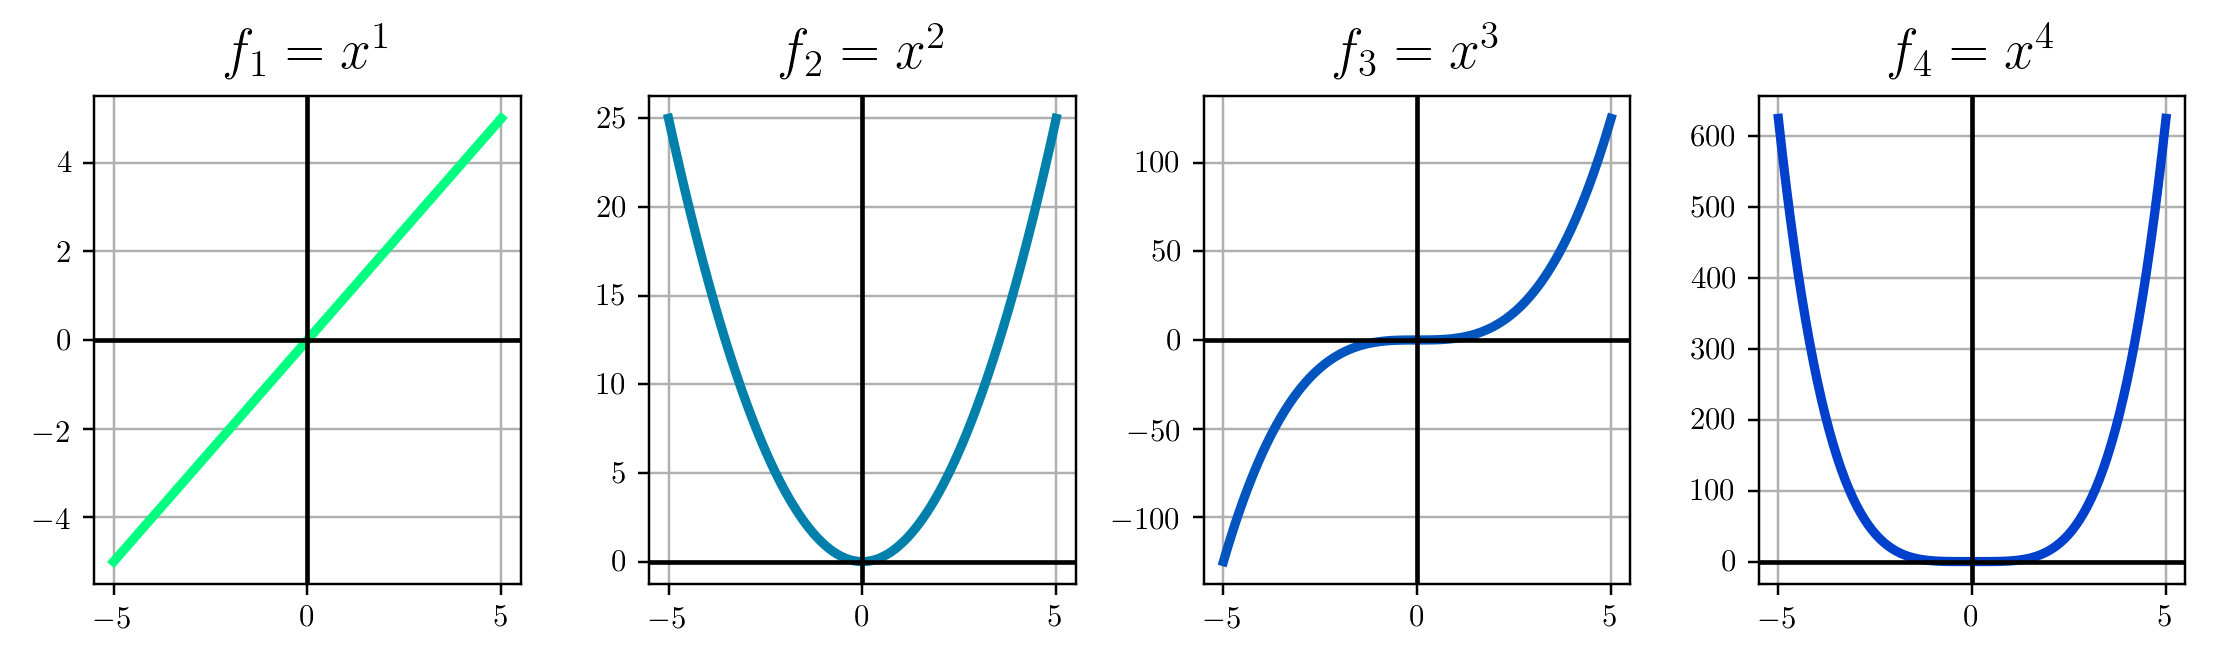

In [93]:
## This code cell will not be shown in the HTML version of this notebook
# build the first 4 non-constant polynomial basis elements
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    fm = x**m
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.plot(fm_table[:,0],fm_table[:,1],color = [0,1/float(m),m/float(m+1)],linewidth = 3)
    ax.set_title('$f_'+str(m) + ' = x^' + str(m) + '$',fontsize = 18)

    # clean up plot
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
plt.show()

In two inputs $x_1$ and $x_2$ polynomial units take the analagous form

\begin{equation}
f_1(x_1,x_2) = x_1, ~~ f_2(x_1,x_2) = x_2^2,  ~~ f(x_1,x_2) = x_1x_2^3, ~~ f(x_1,x_2) = x_1^4x_2^6,...
\end{equation}

with a general degree $D$ unit taking the form 

\begin{equation}
f_b(x_1,x_2) = x_1^px_2^q 
\end{equation}

where where $p$ and $q$ are nonnegative integers and $p + q \leq D$.  A degree $D$ polynomial in this case is a linear combinatino of all such units.  This sort of definition generalizes to defining polynomial units in general $N$ dimensional input as well.  Below we draw a sampling of these polynomial units.

<IPython.core.display.Javascript object>


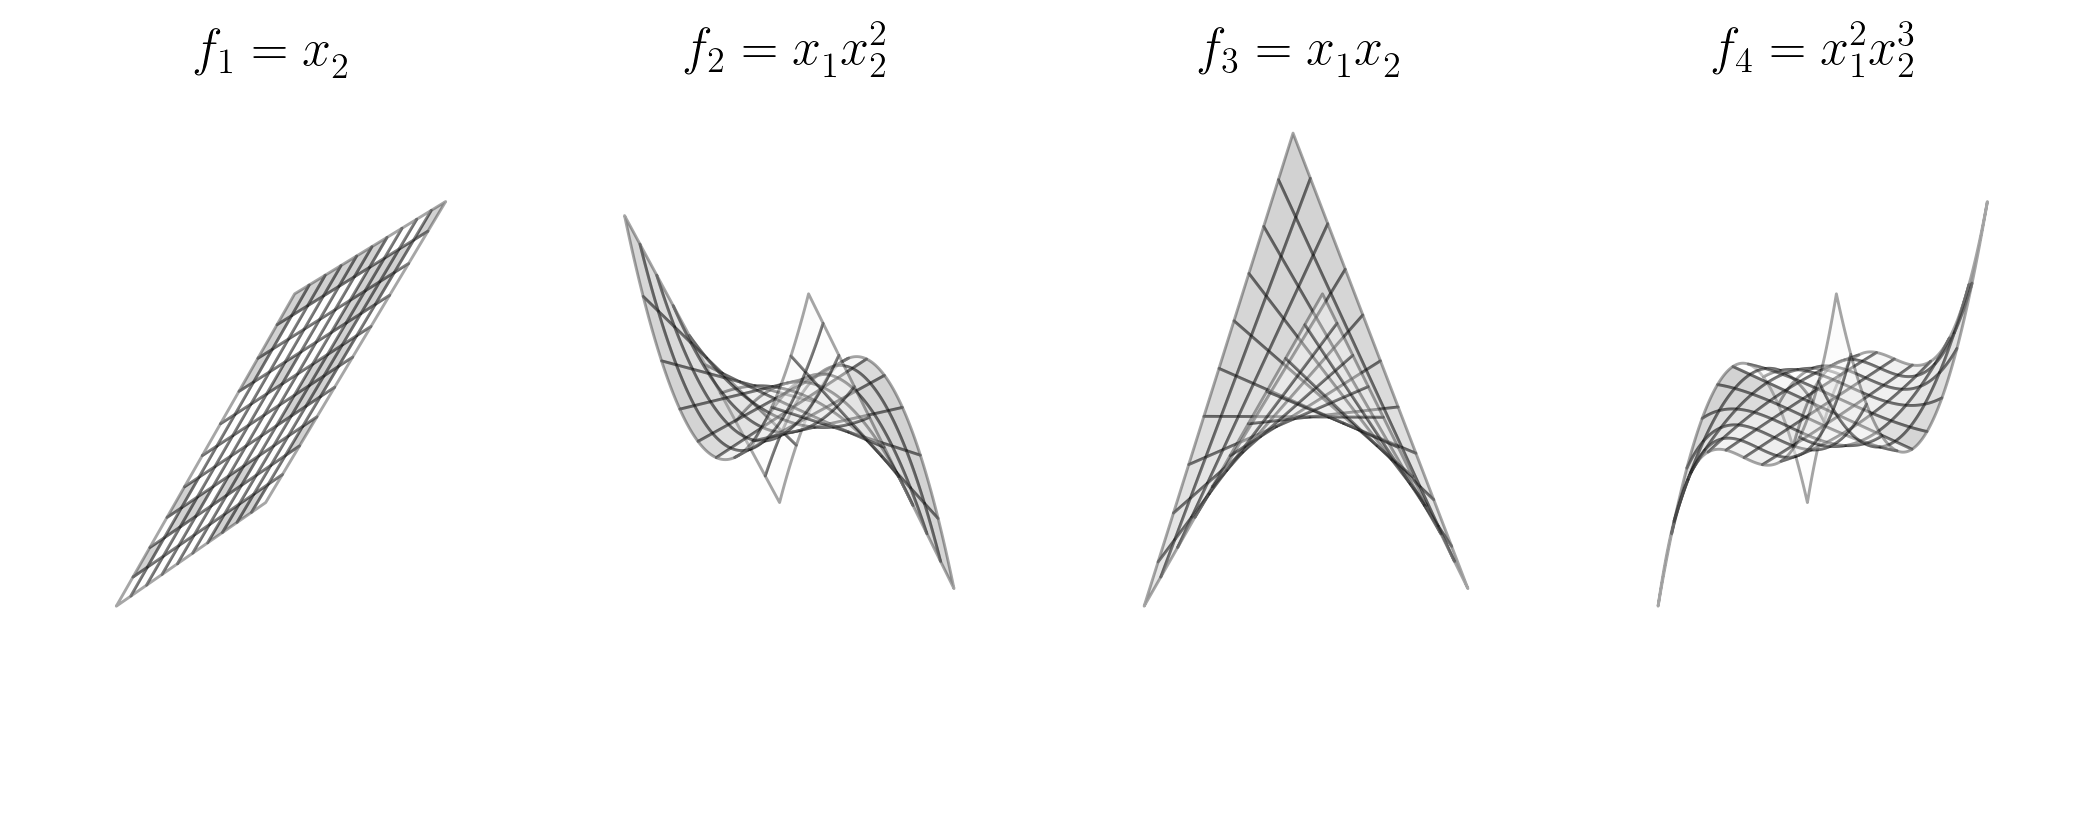

In [19]:
## This code cell will not be shown in the HTML version of this notebook
# generate input values
s = np.linspace(-2,2,100)
x_1,x_2 = np.meshgrid(s,s)
degree_dict = {}

# build 4 polynomial basis elements
fig = plt.figure(num=None, figsize = (10,4), dpi=80, facecolor='w', edgecolor='k')

### plot regression surface ###
p =  [0,1,1,2]
q = [1,2,1,3]
for m in range(4):
    ax1 = plt.subplot(1,4,m+1,projection = '3d')
    ax1.set_axis_off()
    f_m = (x_1**p[m])*(x_2**q[m])
    ax1.plot_surface(x_1,x_2,f_m,alpha = 0.35,color = 'w',zorder = 3,edgecolor = 'k',linewidth=1,cstride = 10, rstride = 10)
    ax1.view_init(20,40)  
    deg1 = ''
    if p[m] == 1:
        deg1 = 'x_1^{\,}'
    if p[m] >=2:
        deg1 = 'x_1^' + str(p[m])
    deg2 = ''
    if q[m] == 1:
        deg2 = 'x_2^{\,}'
    if q[m] >=2:
        deg2 = 'x_2^' + str(q[m])
    ax1.set_title('$f_'+str(m+1) + ' = ' + deg1 + deg2 + '$',fontsize = 18)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)   # remove whitespace around 3d figure
plt.show()

### The neural network family of universal approximators

Another family of universal approximators are *neural networks*.  Broadly speaking neural networks consist of *parameterized* functions whose members - because they are parameterized - have higher capacity being able to take on a variety of different shapes (unlike kernel functions each of which takes on a single fixed form).  The simplest kind of of neural networks universal approximator is a *parameterized elementary function* (e.g., a logistic sigmomid, $tanh$, sinusoidal, or rectified linear unit).  For example, what is referred to as a *single layer* neural with $tanh$ activation consists of nonlinear features of the form

\begin{equation}
f_1(x) = \text{tanh}\left(w_{1,0} + w_{1,1}x\right), ~~ f_2(x) = \text{tanh}\left(w_{2,0} + w_{2,1}x\right), ~~ f_3(x) = \text{tanh}\left(w_{3,0} + w_{3,1}x\right), ~~ f_4(x) = \text{tanh}\left(w_{4,0} + w_{4,1}x\right), ...
\end{equation}


Notice that because there are parameters inside the $\text{tanh}$ the $b^{th}$ such function $f_b$ can take on a variety of shapes depending on how we set its *internal parameters* $w_{b,0}$ and $w_{b,1}$.  We illustrate this below by randomly setting these two values and plotting the table of the associated function.

<IPython.core.display.Javascript object>


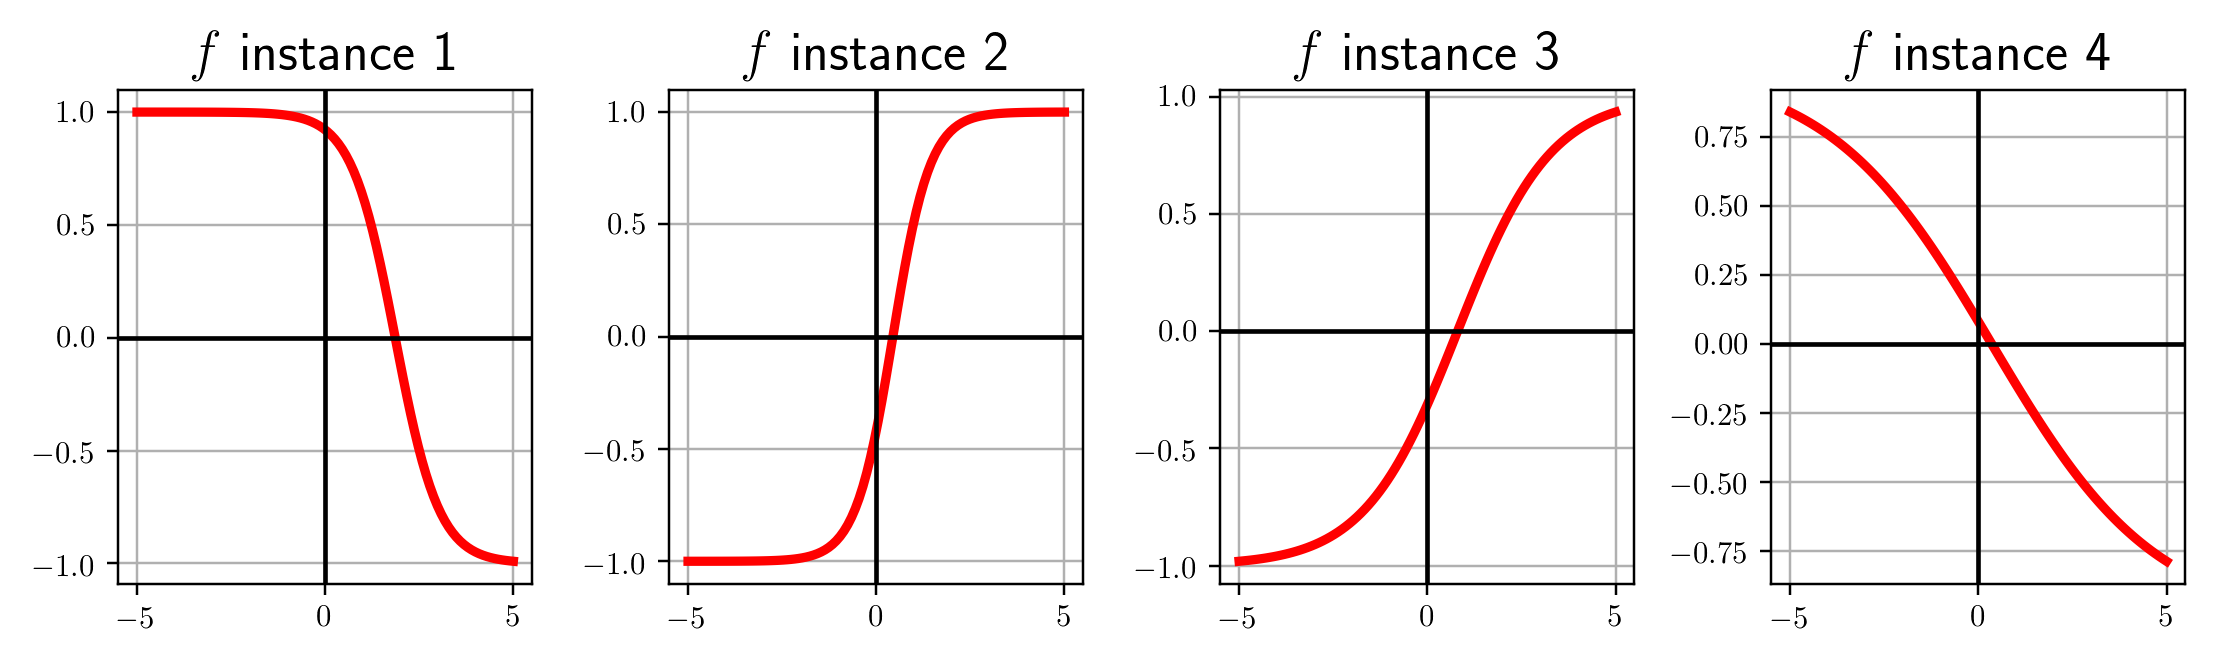

In [94]:
## This code cell will not be shown in the HTML version of this notebook
# build 4 instances of a composition basis: line and tanh
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    w_0 = np.random.randn(1)
    w_1 = np.random.randn(1)
    fm = np.tanh(w_0 + w_1*x)
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.plot(fm_table[:,0],fm_table[:,1],c='r',linewidth = 3)
    ax.set_title('$f$ instance ' + str(m),fontsize = 18)

    # clean up plot
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

plt.show()

To handle higher dimensional input we simply take a linear combination of the input, passing the result through the nonlinear function.  For example, an element $f_b$ for general $N$ dimensional input looks like the following using the $tanh$ function

\begin{equation}
f_b\left(\mathbf{x}\right) = \text{tanh}\left(w_{b,0} + w_{b,1}x_1 + \cdots + w_{b,\,N}x_N\right).
\end{equation}

As with the lower dimensional single layer functions, each such function can take on a variety of different shapes based on how we tune its internal parameters.  Below we show $4$ instances of such a function with $N=2$ dimensional input.

<IPython.core.display.Javascript object>


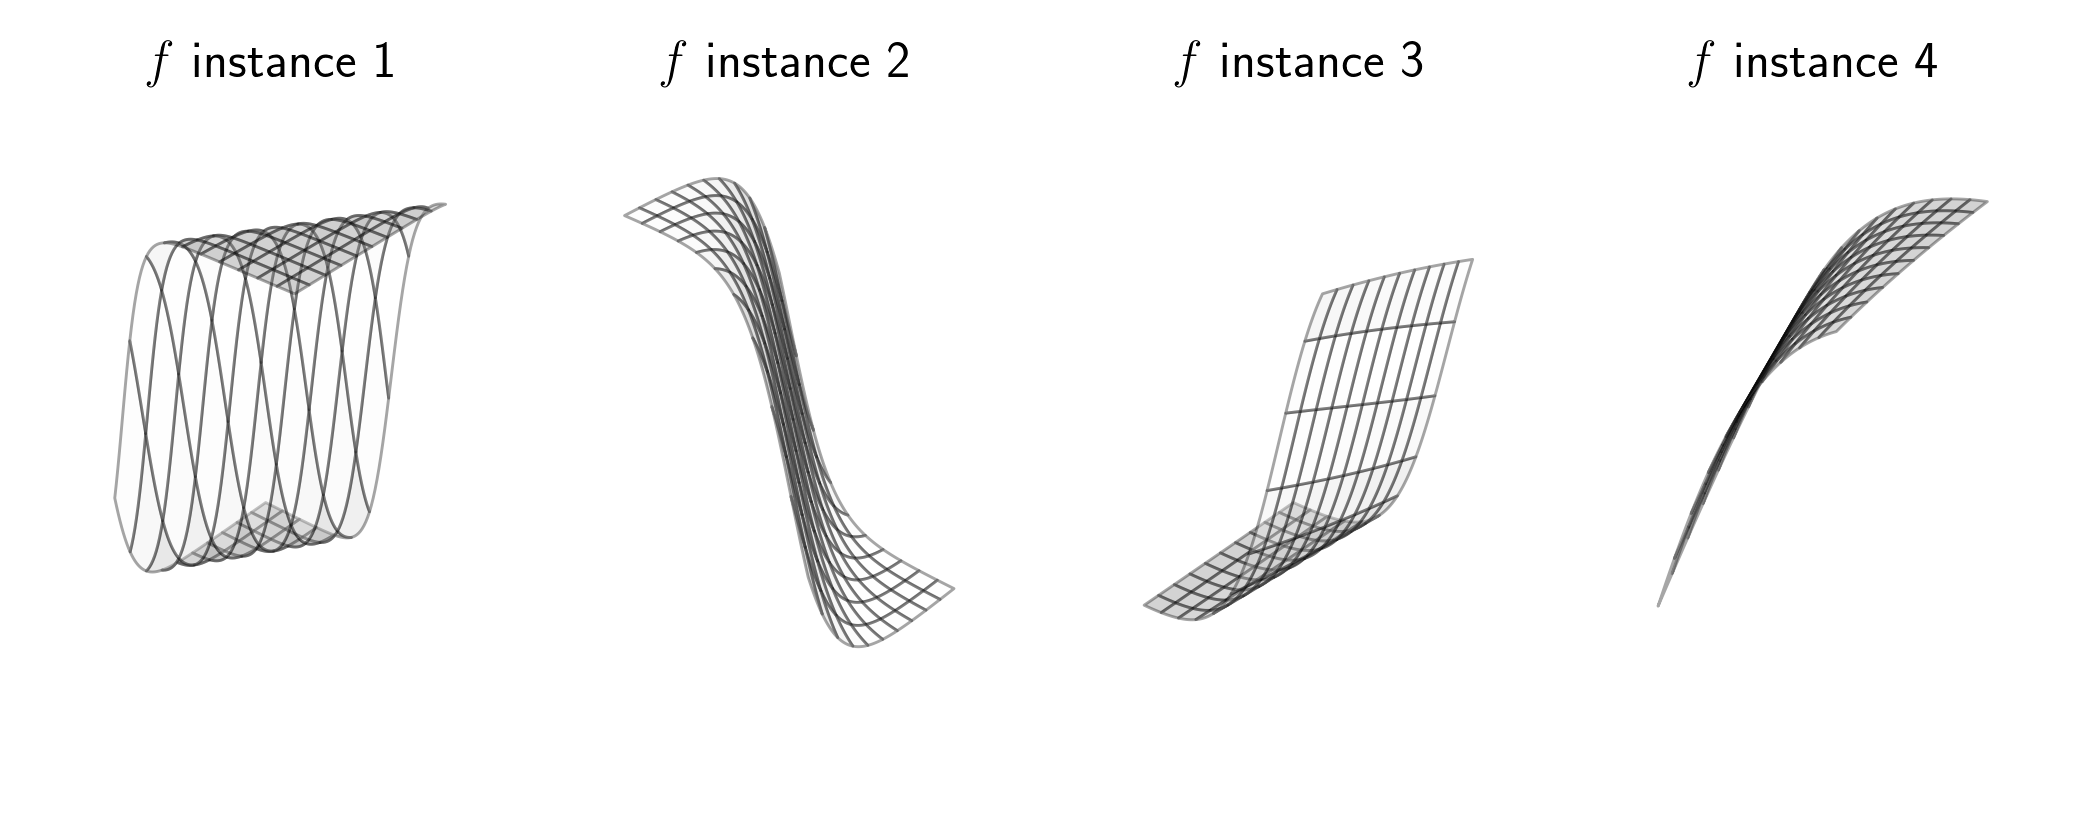

In [6]:
## This code cell will not be shown in the HTML version of this notebook
# generate input values
s = np.linspace(-2,2,100)
x_1,x_2 = np.meshgrid(s,s)
degree_dict = {}

# build 4 polynomial basis elements
fig = plt.figure(num=None, figsize = (10,4), dpi=80, facecolor='w', edgecolor='k')

### plot regression surface ###
p =  [0,1,1,2]
q = [1,2,1,3]
for m in range(4):
    ax1 = plt.subplot(1,4,m+1,projection = '3d')
    ax1.set_axis_off()
    
    # random weights
    w_0 = np.random.randn(1)
    w_1 = np.random.randn(1)
    w_2 = np.random.randn(1)
    w_3 = np.random.randn(1)
    f_m = w_3*np.tanh(w_0 + w_1*x_1 + w_2*x_2)

    ax1.plot_surface(x_1,x_2,f_m,alpha = 0.35,color = 'w',zorder = 3,edgecolor = 'k',linewidth=1,cstride = 10, rstride = 10)
    ax1.view_init(20,40) 
    ax1.set_title('$f$ instance ' + str(m+1),fontsize = 18)

fig.subplots_adjust(left=0,right=1,bottom=0,top=1)   # remove whitespace around 3d figure
plt.show()

### The tree family of universal approximators

Like neural networks, a single element from the family of tree-based universal approximators can take on a wide array of shapes.  The simplest sort of tree basis consists of discrete step functions or, as they are more commonly referred to, *stumps* whose break lies along a single dimension of the feature space.  A stump with 1-dimensional input $x$ can be written as 

\begin{equation}
f_1(x) = \begin{cases} x < V_1 \,\,\,\,\, a_1 \\ x \geq  V_1 \,\,\,\,\, b_1   \end{cases}  ~~~~~~~~
f_2(x) = \begin{cases} x < V_2 \,\,\,\,\, a_2 \\ x \geq  V_2 \,\,\,\,\, b_2  \end{cases} ~~ \cdots
\end{equation}


where $V_{1}$ is split point at which the stump changes values, and $y_{1}$ and $y_{2}$ are values taken by the two sides of the stump, respectively, which we refer to as *levels* of the stump.

Below we plot four instances of such a stump basis element - where we can see how each one takes on a wide variety of shapes.

<IPython.core.display.Javascript object>


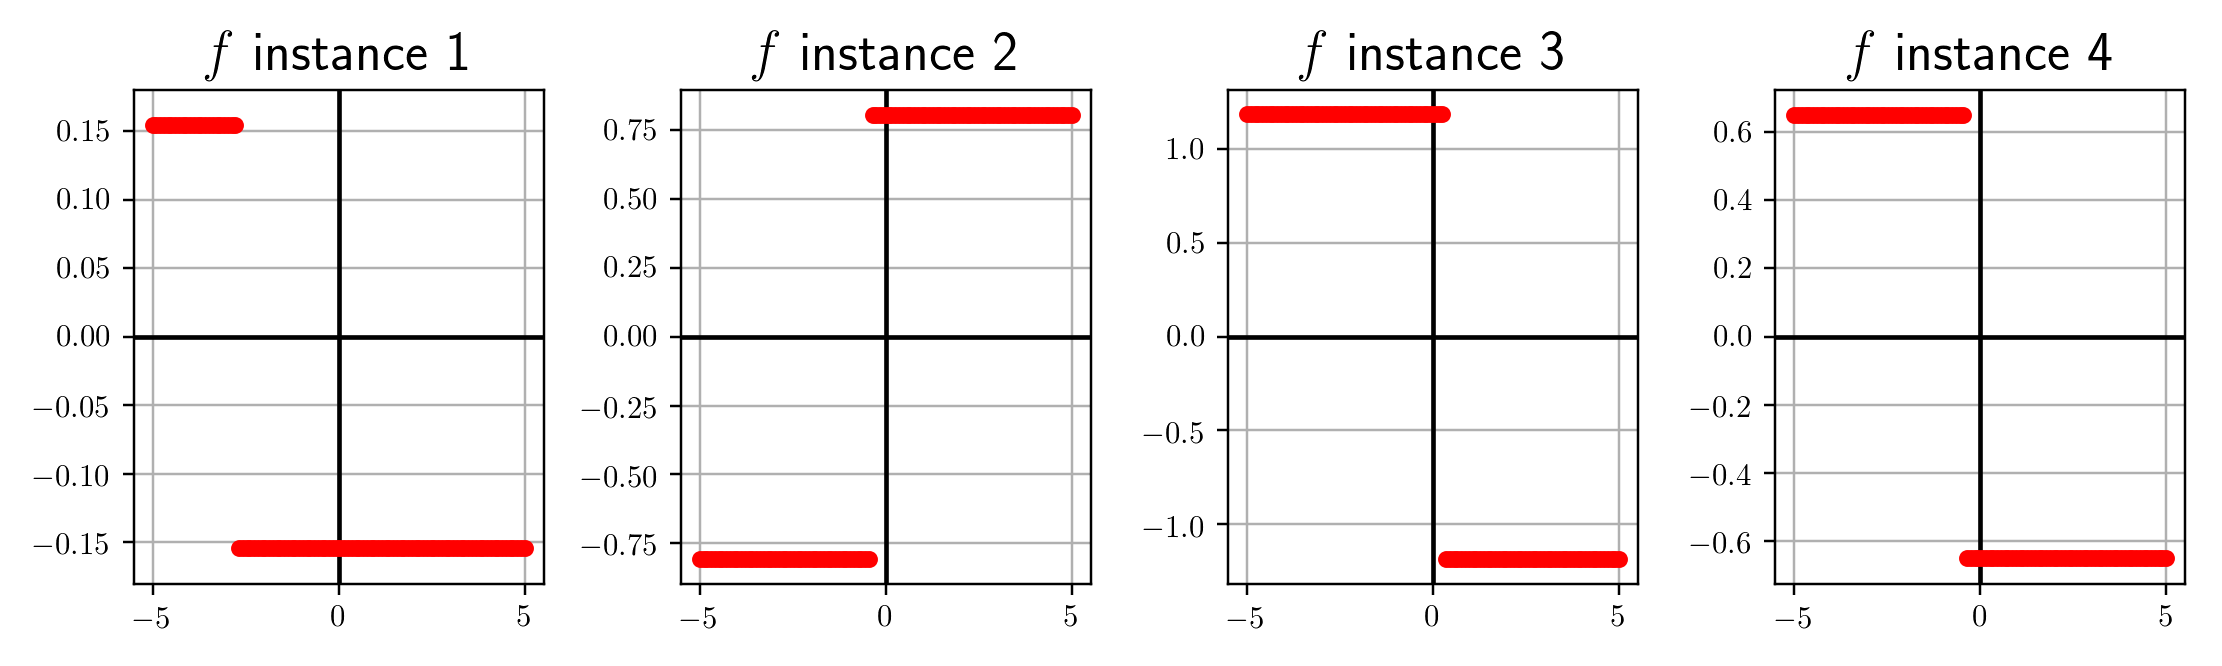

In [112]:
## This code cell will not be shown in the HTML version of this notebook
# build 4 instances of a composition basis: line and tanh
x = np.linspace(-5,5,100)
fig = plt.figure(figsize = (10,3))

for m in range(1,5):
    # make basis element
    w_0 = np.random.randn(1)
    w_1 = np.random.randn(1)
    w_2 = np.random.randn(1)
    fm = w_2*np.sign(w_0 + w_1*x)
    fm_table = np.stack((x,fm),axis = 1)
    
    # plot the current element
    ax = fig.add_subplot(1,4,m)
    ax.scatter(fm_table[:,0],fm_table[:,1],c='r',s = 20,zorder = 3)
    ax.set_title('$f$ instance ' + str(m),fontsize = 18)

    # clean up plot
    ax.grid(True, which='both')
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

plt.show()

Higher dimensional stumps follow this one dimensional pattern: a split point $V_1$ is defined along a *single* dimension, defining a linear step along a single coordinate dimension.  Each side of the split is then assigned a single level value.  Below we plot four instances of a single stump defined in two dimensions.  Here the split point is defined along a value on either the $x_1$ or $x_2$ axis, producing a step that is a line along one coordinate axes. 

<IPython.core.display.Javascript object>


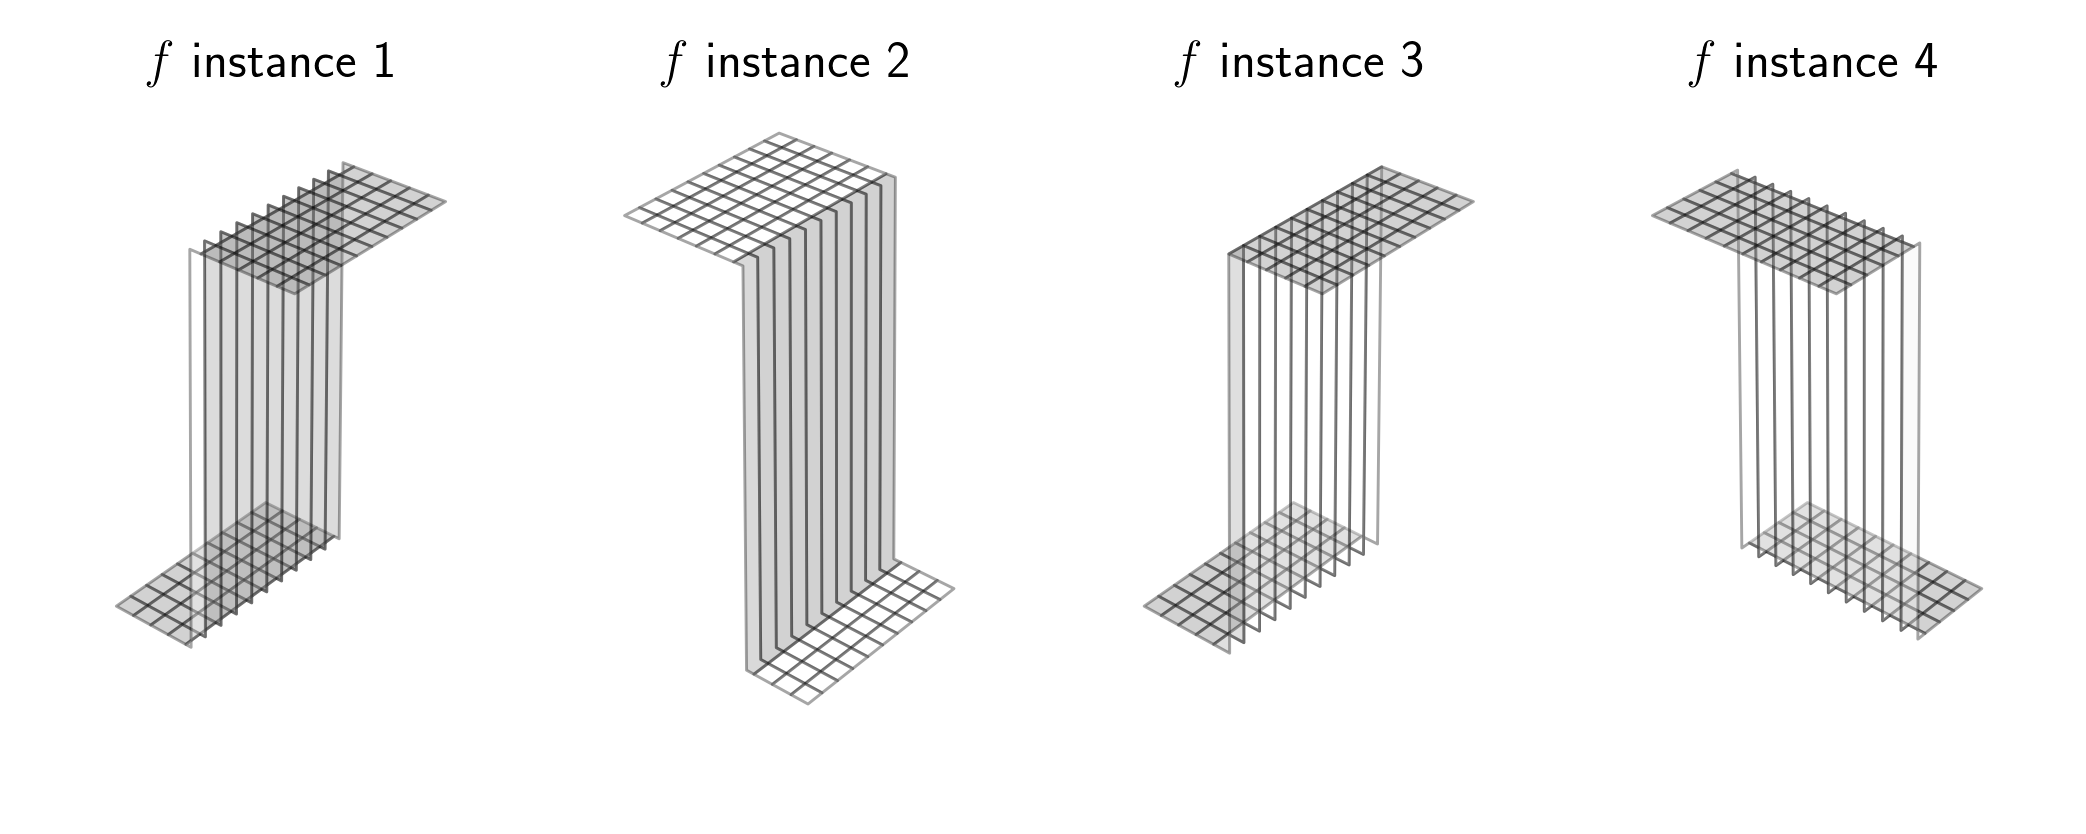

In [46]:
## This code cell will not be shown in the HTML version of this notebook
# generate input values
s = np.linspace(-2,2,100)
x_1,x_2 = np.meshgrid(s,s)
degree_dict = {}

# build 4 polynomial basis elements
fig = plt.figure(num=None, figsize = (10,4), dpi=80, facecolor='w', edgecolor='k')

### plot regression surface ###
for m in range(4):
    ax1 = plt.subplot(1,4,m+1,projection = '3d')
    ax1.set_axis_off()
    
    # random weights
    r = np.random.randint(2)
    w_0 = 0.1*np.random.randn(1)
    w_1 = np.random.randn(1)*r
    w_2 = np.random.randn(1)*(1 - r)
    w_3 = 3*np.random.randn(1)
    f_m = w_3*np.sign(w_0 + w_1*x_1 + w_2*x_2)
    
    ax1.plot_surface(x_1,x_2,f_m,alpha = 0.35,color = 'w',zorder = 3,edgecolor = 'k',linewidth=1,cstride = 10, rstride = 10)
    ax1.view_init(20,40) 
    ax1.set_title('$f$ instance ' + str(m+1),fontsize = 18)

fig.subplots_adjust(left=0,right=1,bottom=0,top=1)   # remove whitespace around 3d figure
plt.show()

## 11.1.5 Feature learning examples

Here we examine a number of examples of feature learning for perfect regression and two-class classification data.  In this context any of the major universal approximators - whether they be kernels, neural networks, or trees - can all provide perfect representation if $B$ is chosen large enough, and we are able to tune the parameters of a corresponding cost function well enough.  In the case where such a dataset is *infinitely* large this would, in theory, require *an infinite computing power* (imagine trying to minimize a Softmax cost function over a dataset of size $P = \infty$).  Because of this the examples in this Section are not really 'perfect' in the senes that they are finite in size, since in each case we employ a model consisting of univeral approximators and tune its parameters via minimization of an appropriate cost function (using e.g., gradient descent).

Notice in the examples here as well as those detailed in the future, when constructing an individual model with universal approximator feature transformations we units from a single kind of universal approximator described above.  That is, we do not mix exemplars from different univeral approximator families - using e.g., a few polynomial units and a few tree units in the same model.  This is done for several reasons.  First and foremost - as we will see in Chapters following this one (with one Chapter dedicated to additional technical details relating to each universal approximator family) - by restricting a model's feature transforms to a single family we can (in each of the three cases) better optimize the learning process, deal with each families' unique eccentricities, and (as we detail in the Section following this one) with real data manage our search the proper model capacity.

#### <span style="color:#a50e3e;">Example 2. </span>   Examples of universal approximation perfect regression and classification data

Blow we show a close-to perfect regression dataset consisting of $P = 10,000$ input/output points in black, and we approximate this function using $B = 300$ universal approximators (in this particular example we use the $tanh$ neural network approximators described above) tuning the parameters of $\Theta$ by minimizing the corresponding Least Squares cost via gradient descent.  As you move the slider from left to right you will see a red curve jump onto the screen - this is the combination of our $300$ universal approximators shown first with a poor choice of parameter settings.  As yo move the slider from left to right we illustrate how the shape of this combination improves (in terms of how it approximates $y\left(\mathbf{x}\right)$) as we improve the setting of its parameters.  Eventually - moving the slider all the way to the right where we show an especially good setting of these parameters -  the combination approximates $y$ quite well (and indeed if we kept refining its parameters it could perfectly represent $y$).


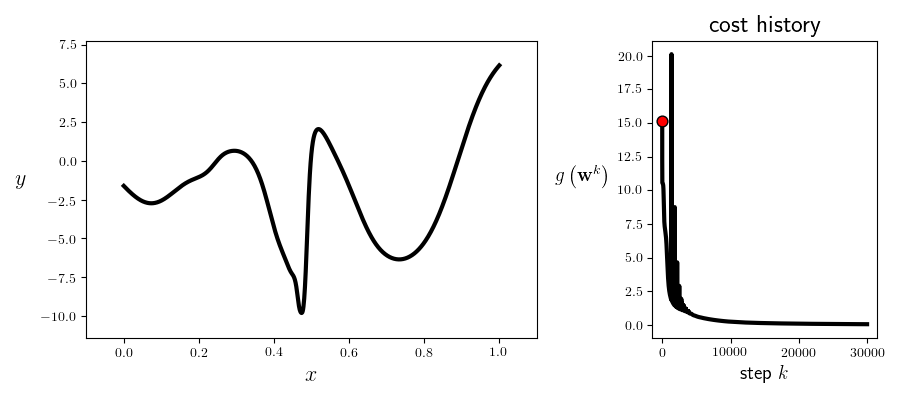
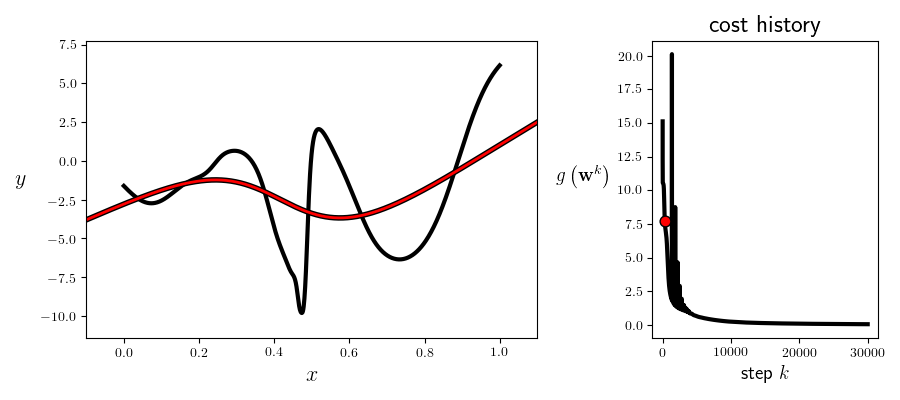
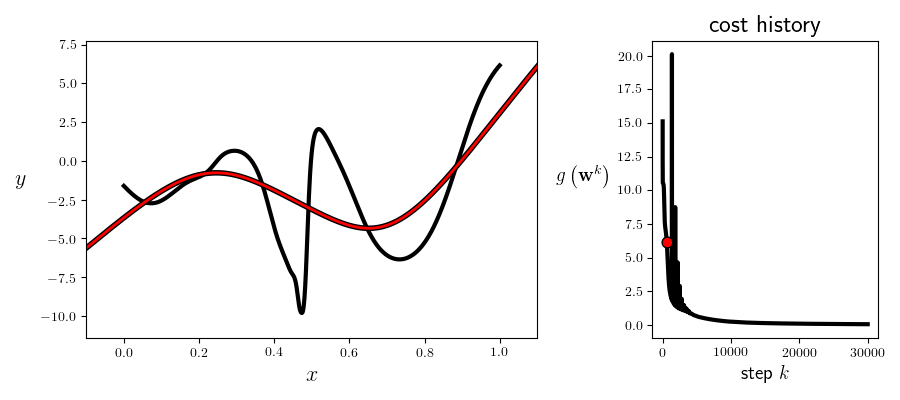
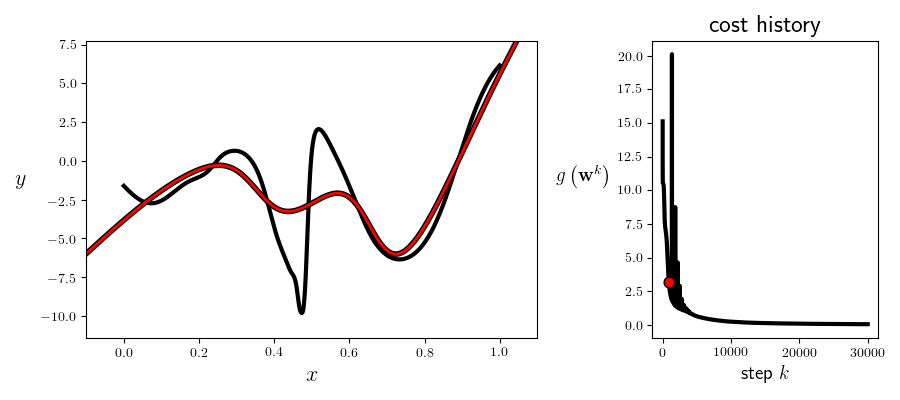
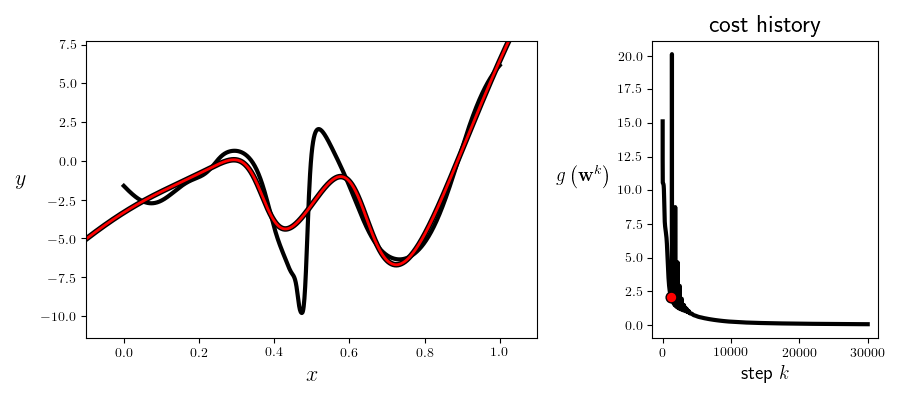
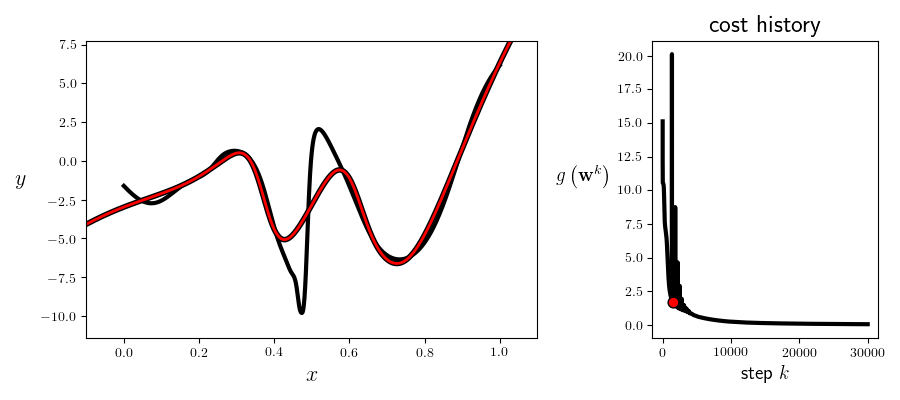
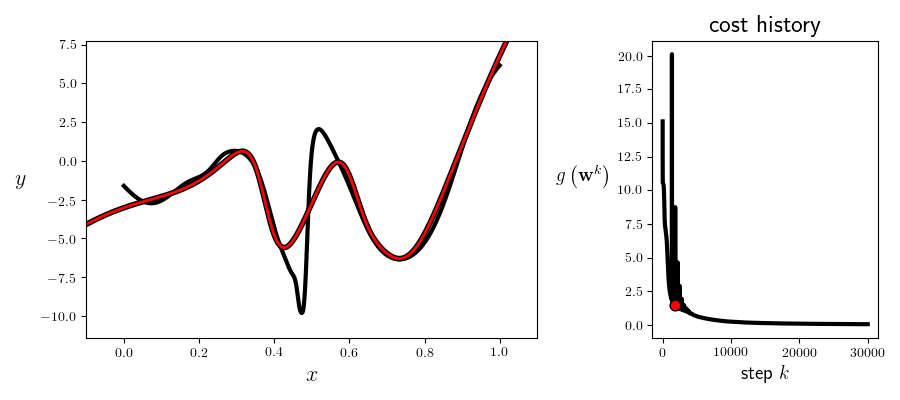
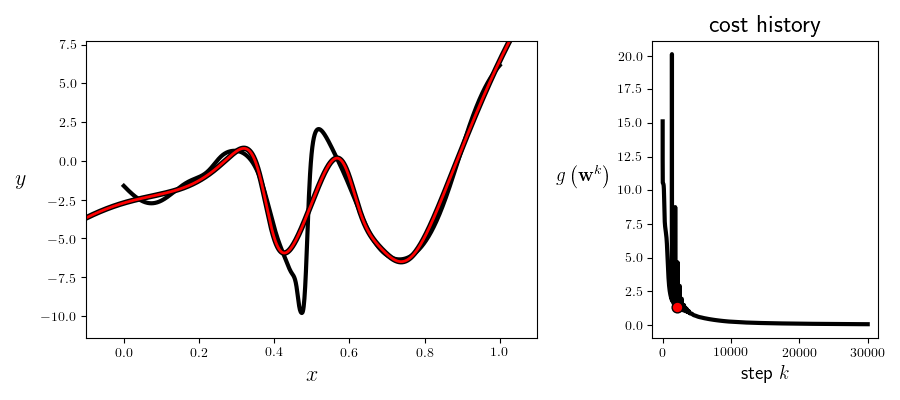
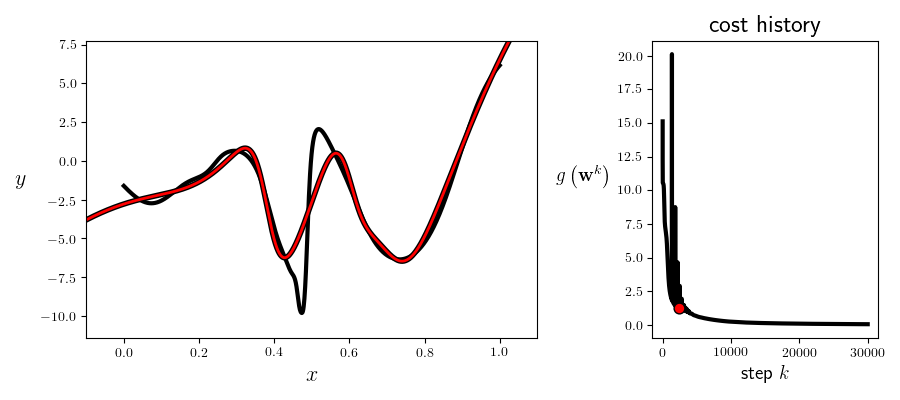
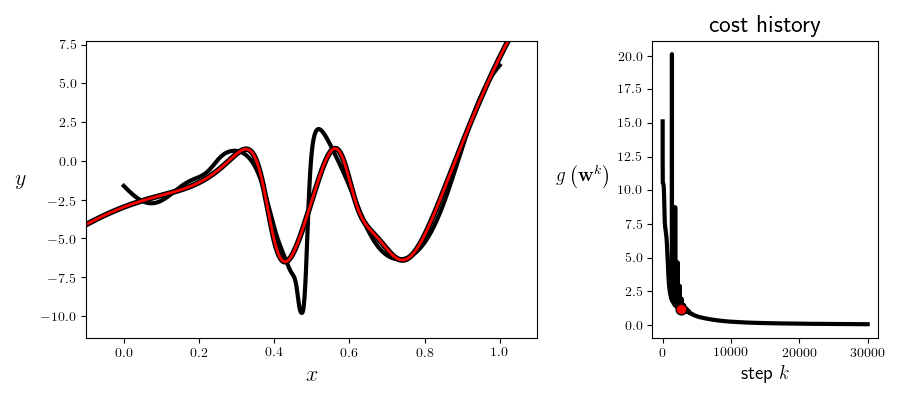
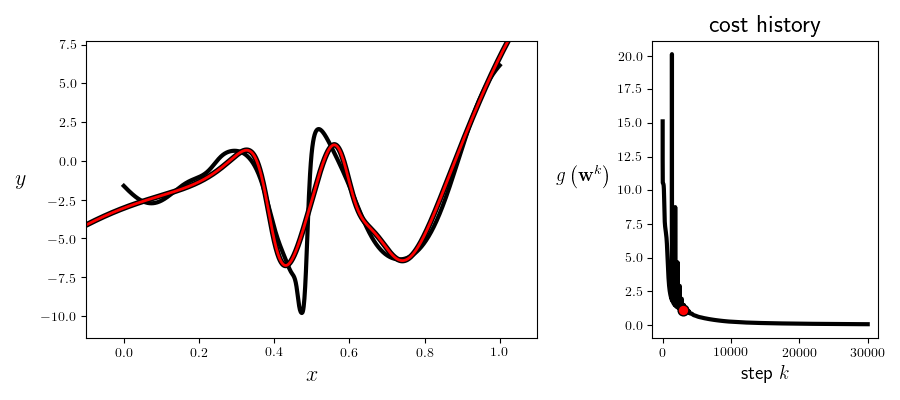
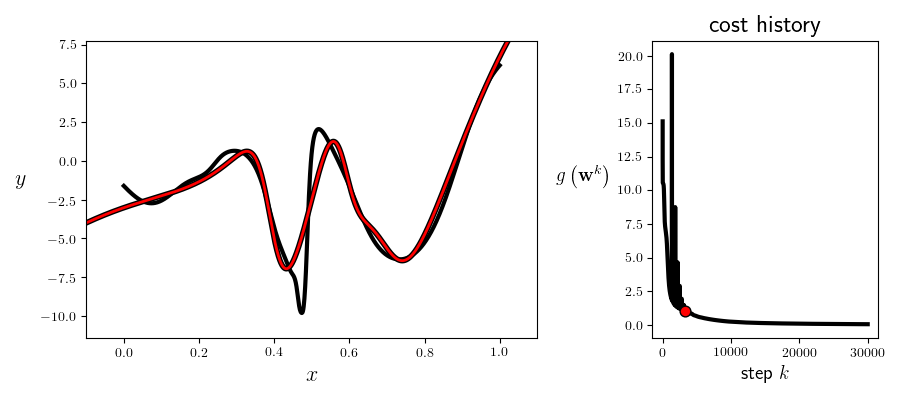
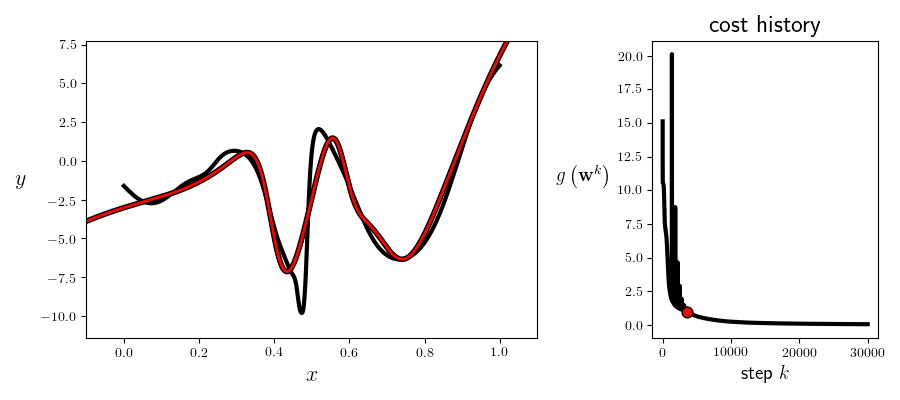
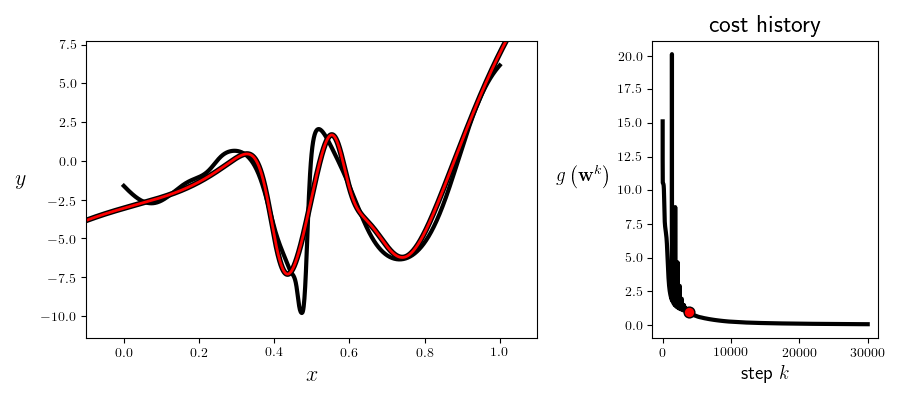
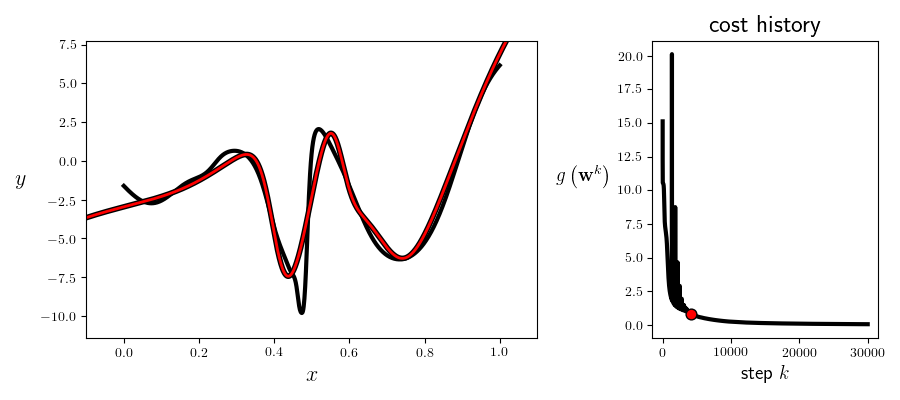
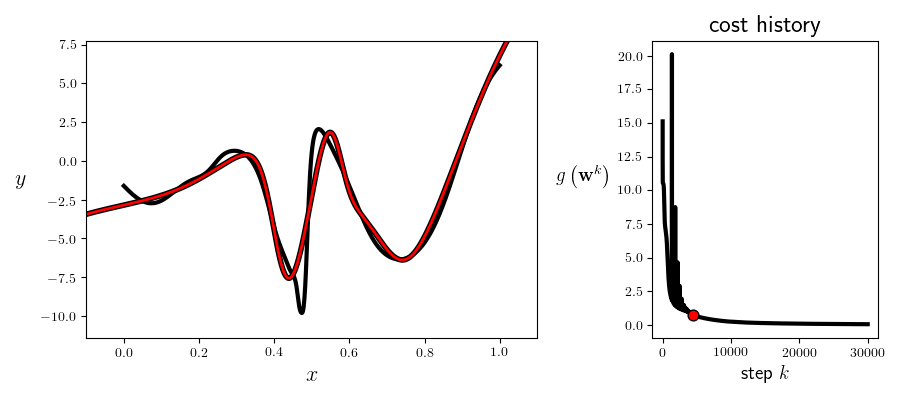
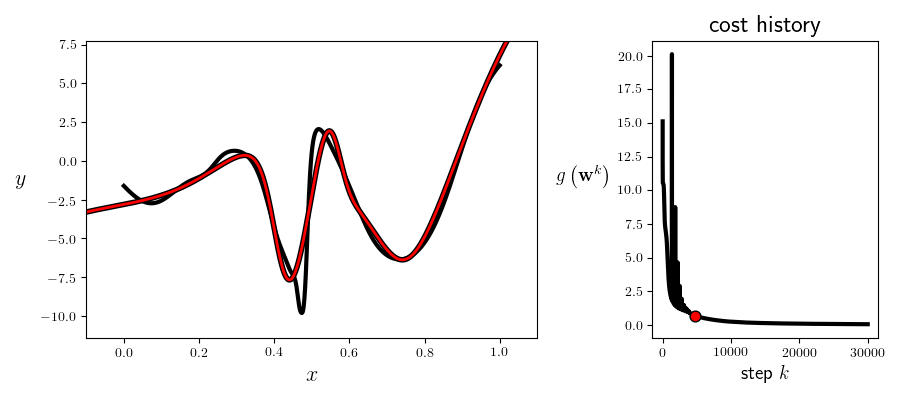
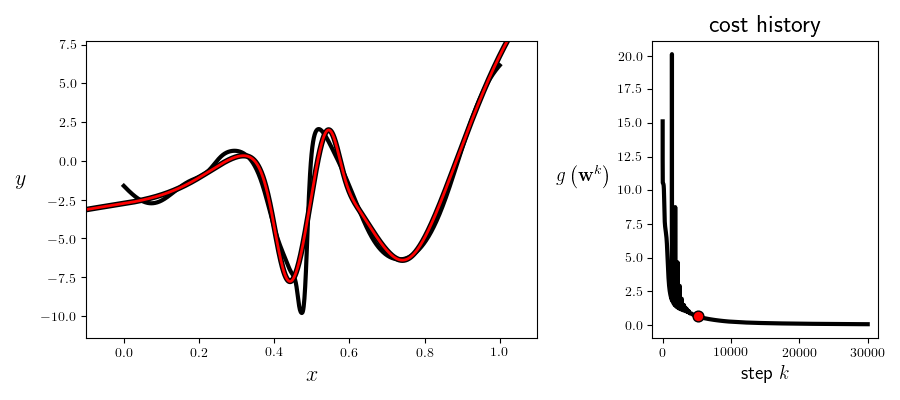
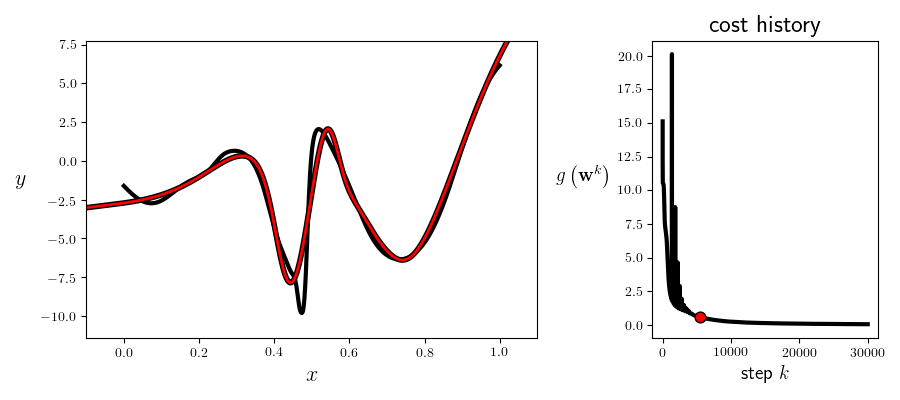
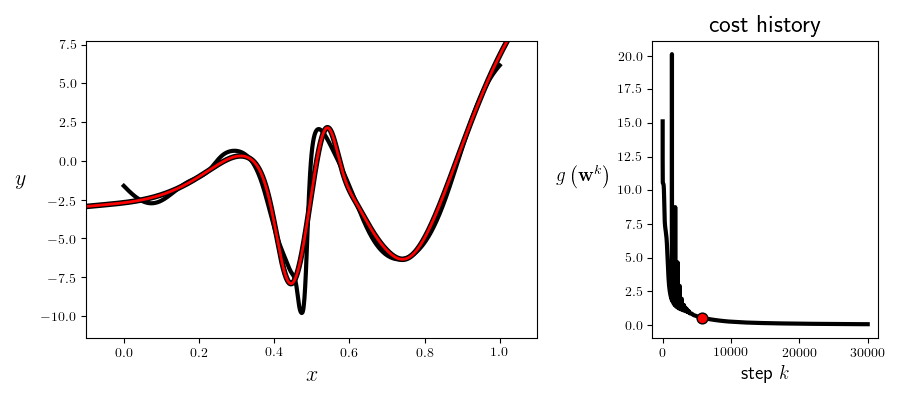
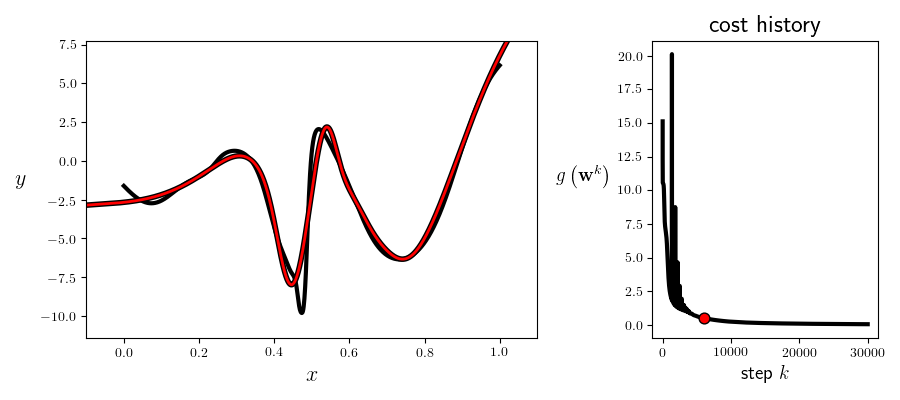
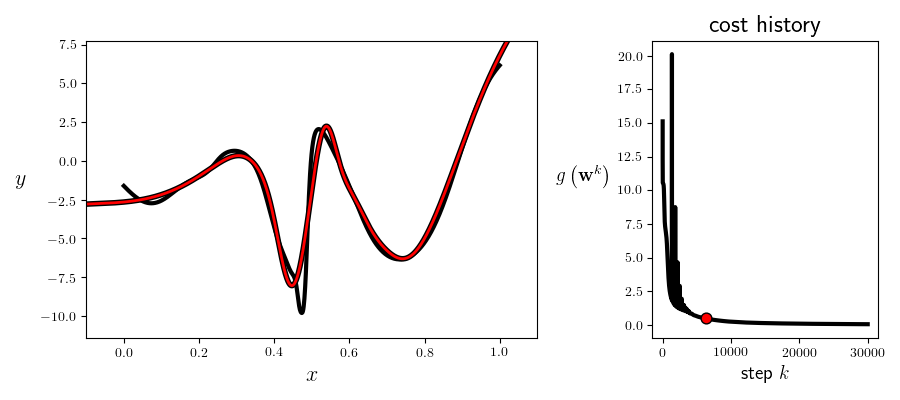
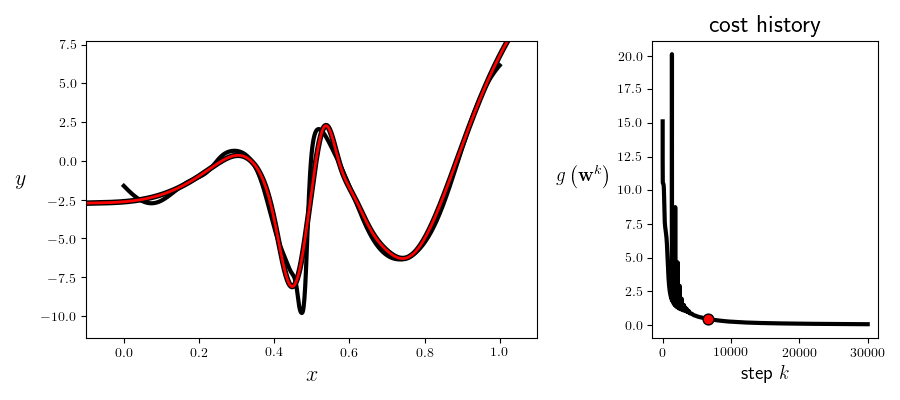
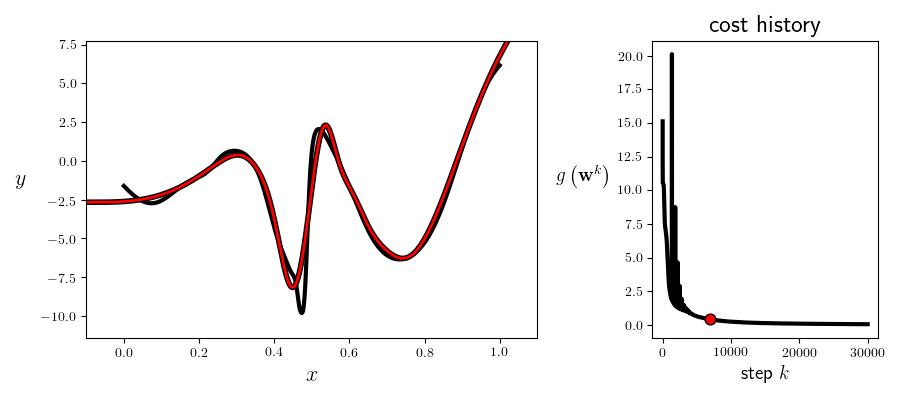
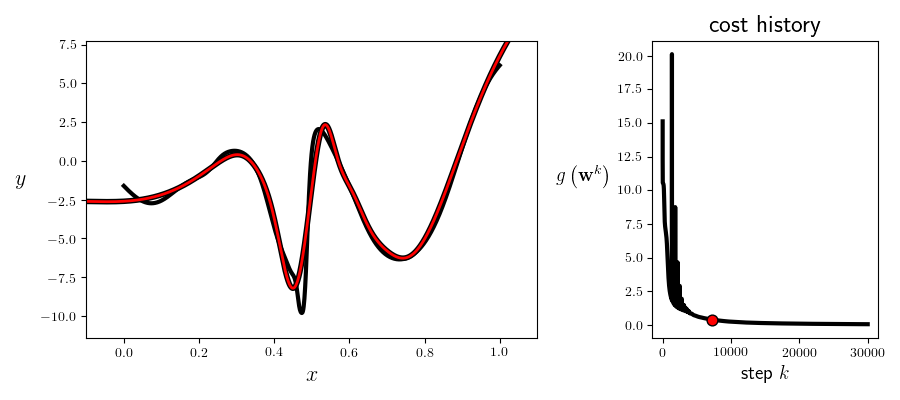
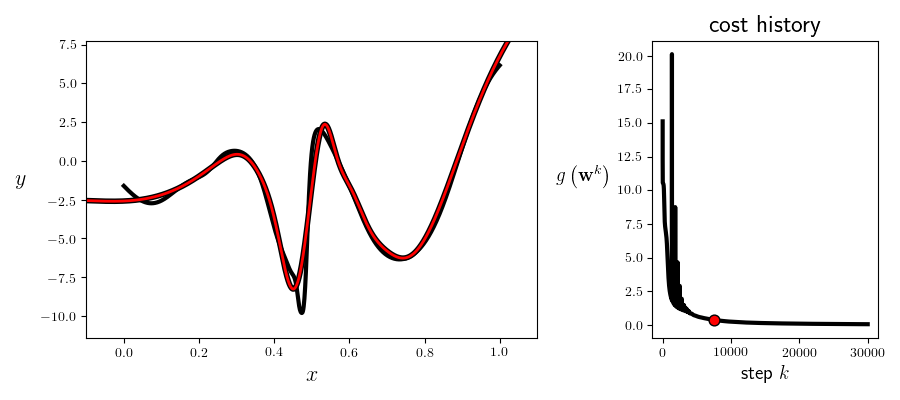
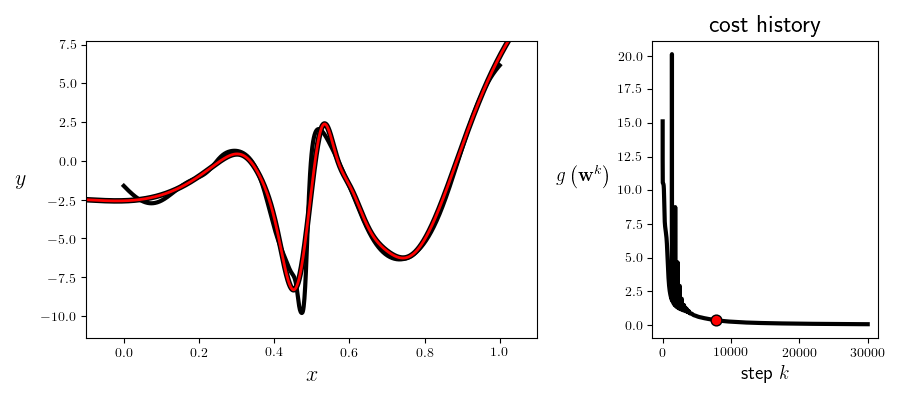
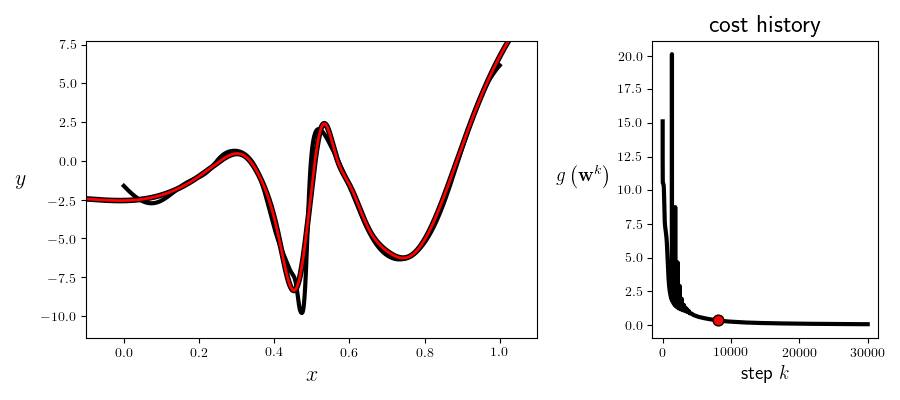
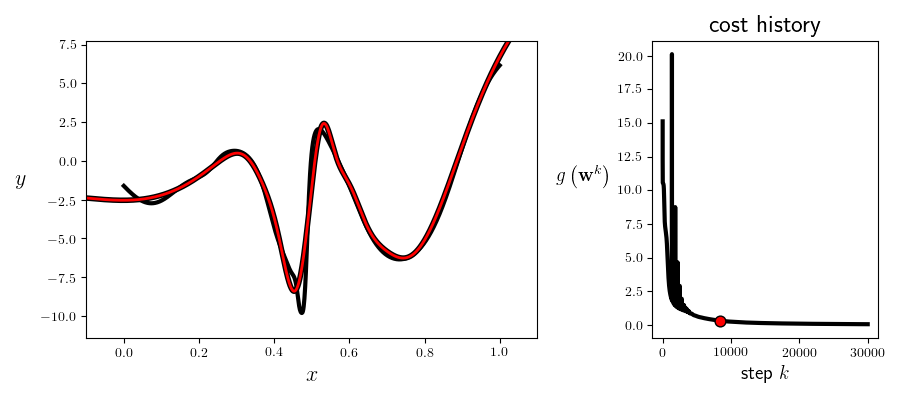
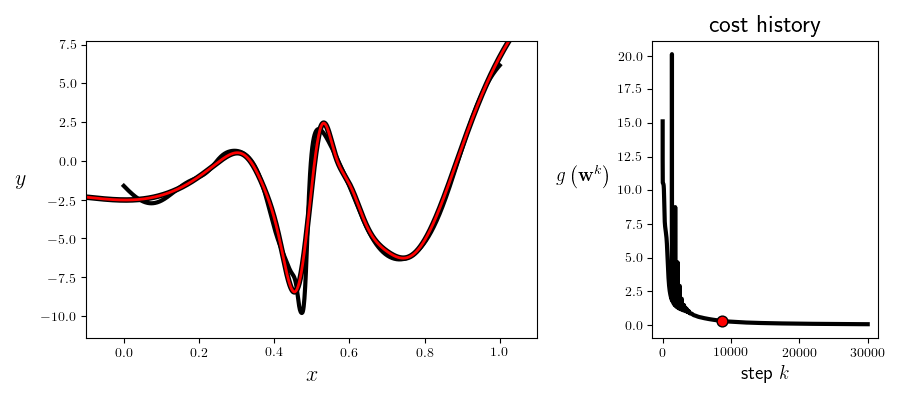
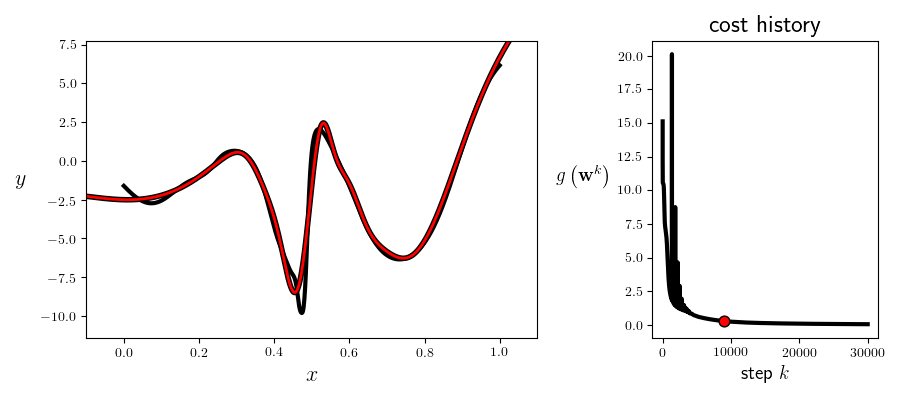
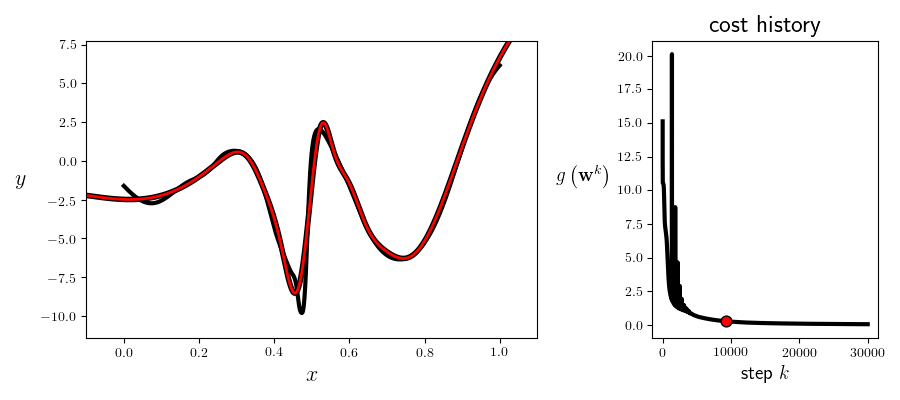
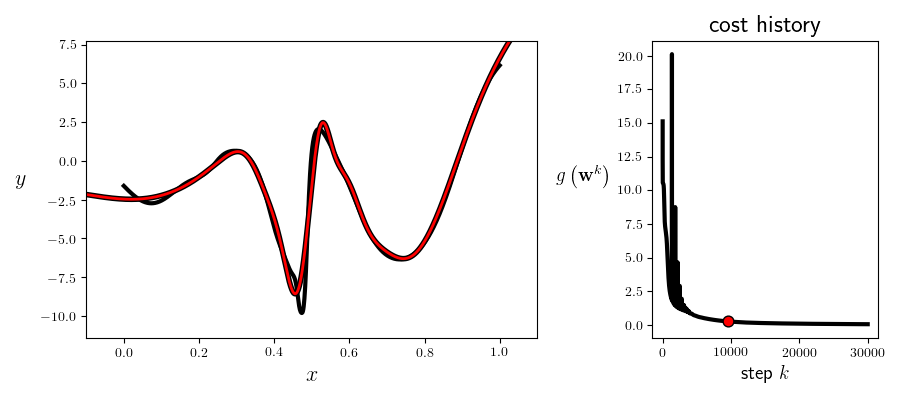
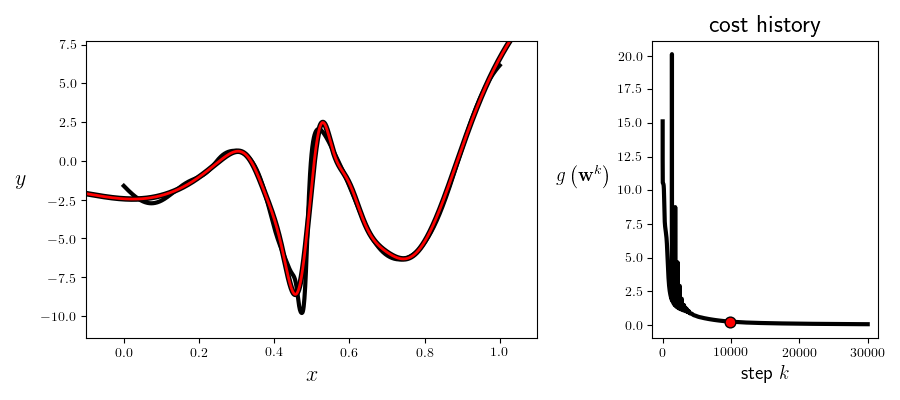
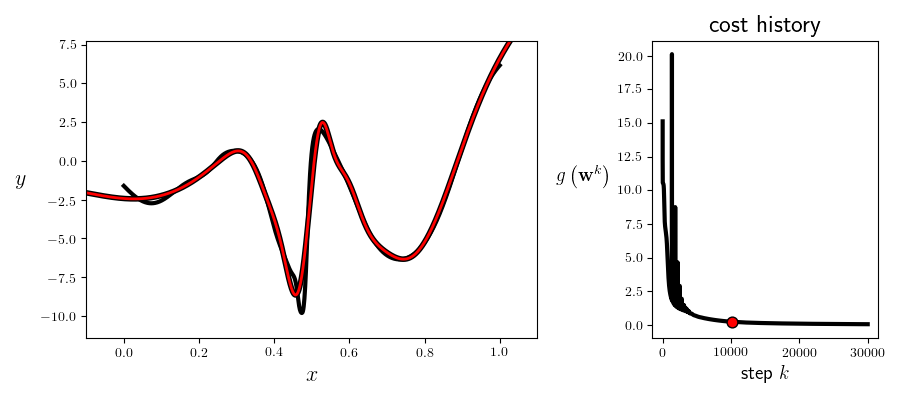
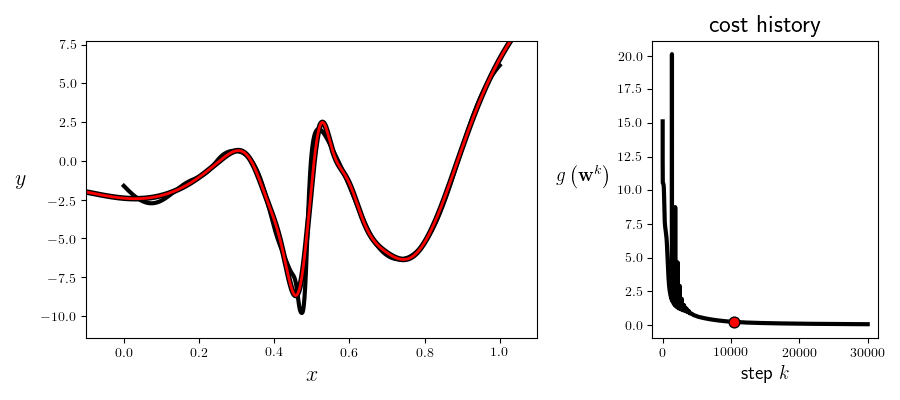
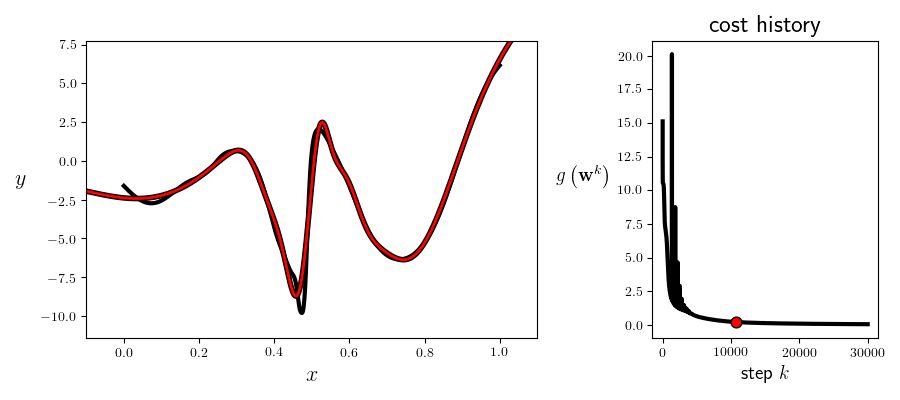
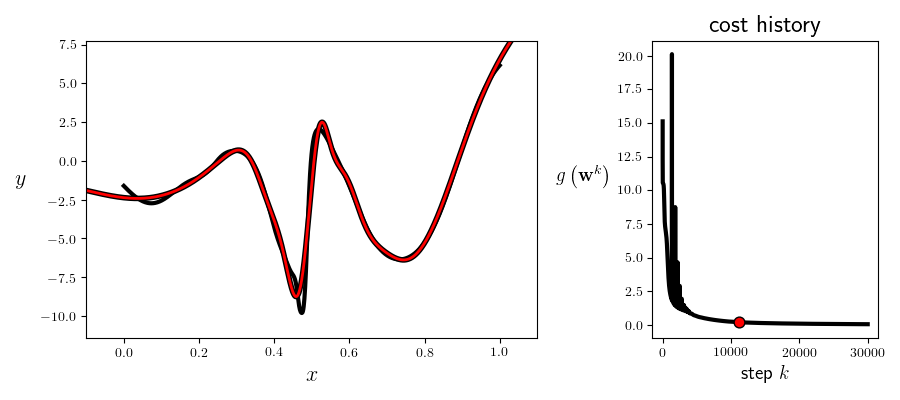
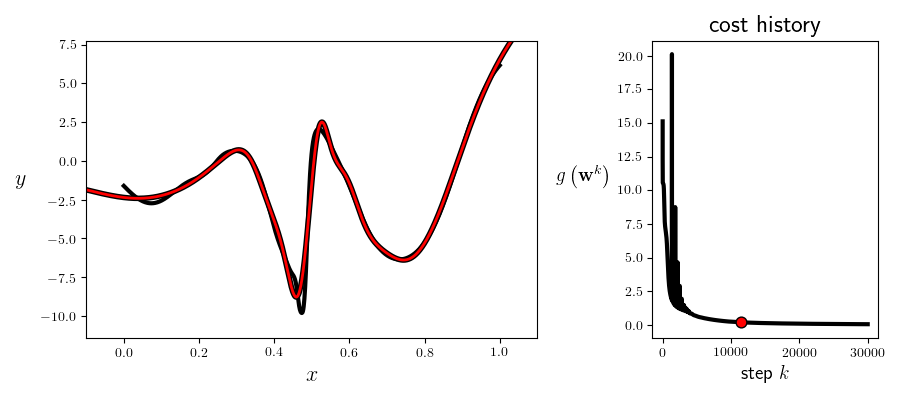
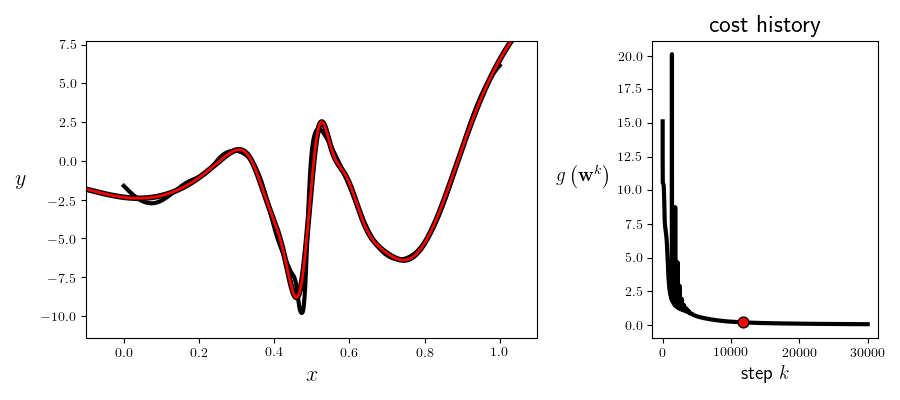
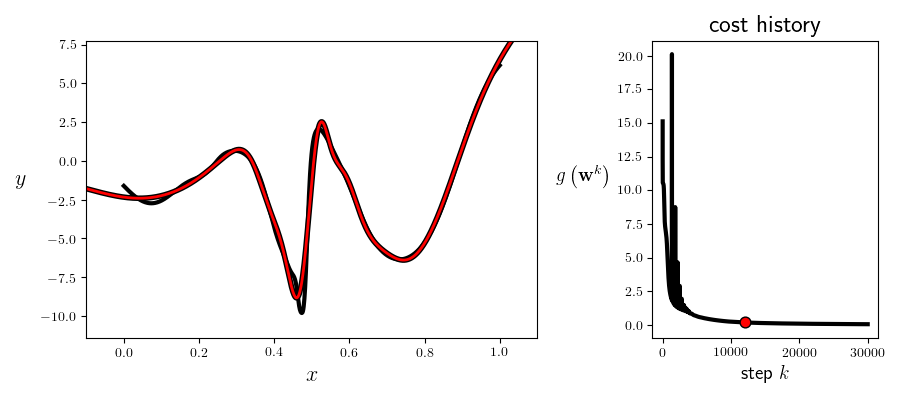
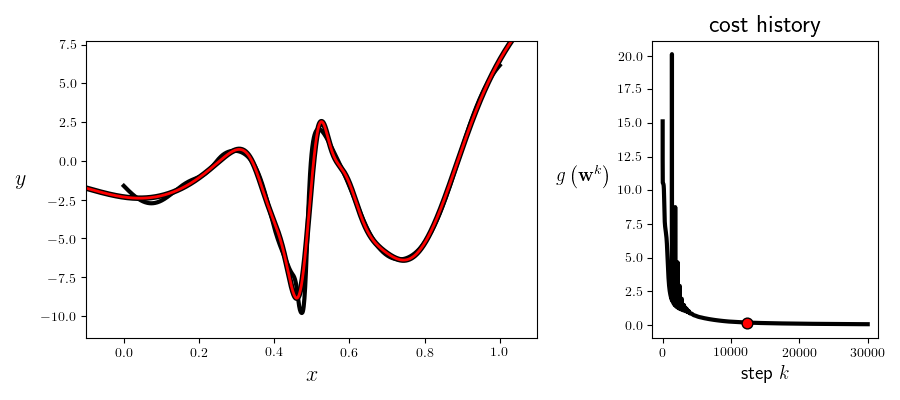
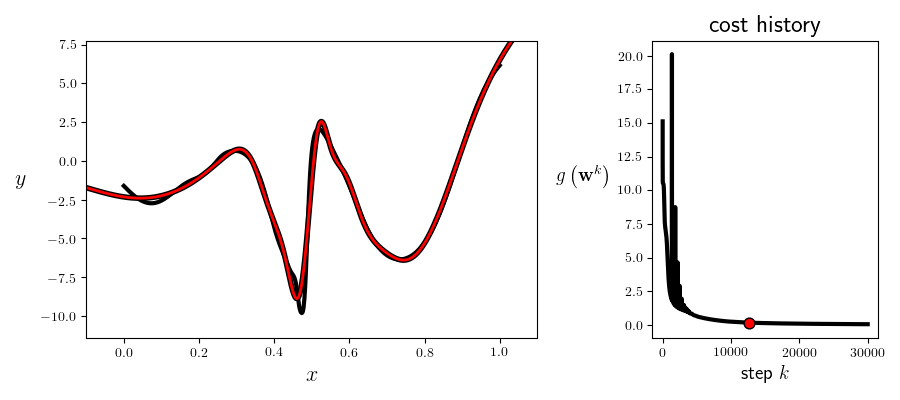
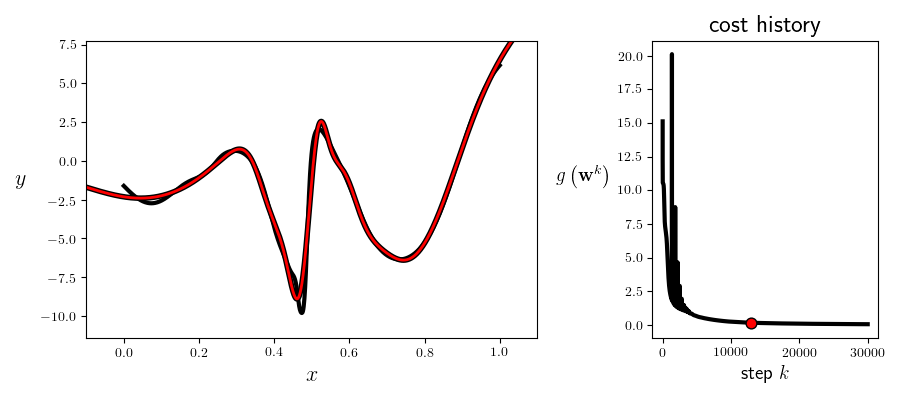
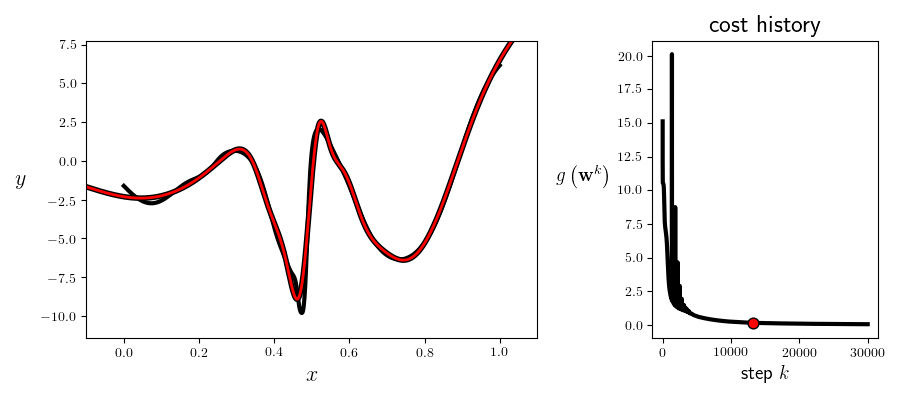
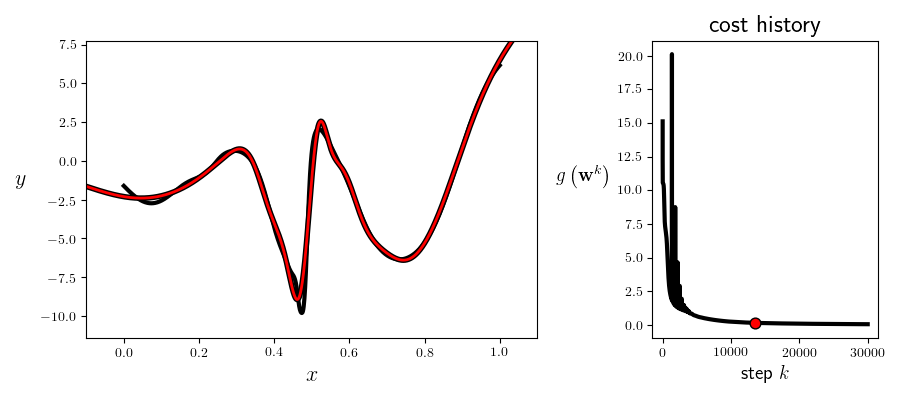
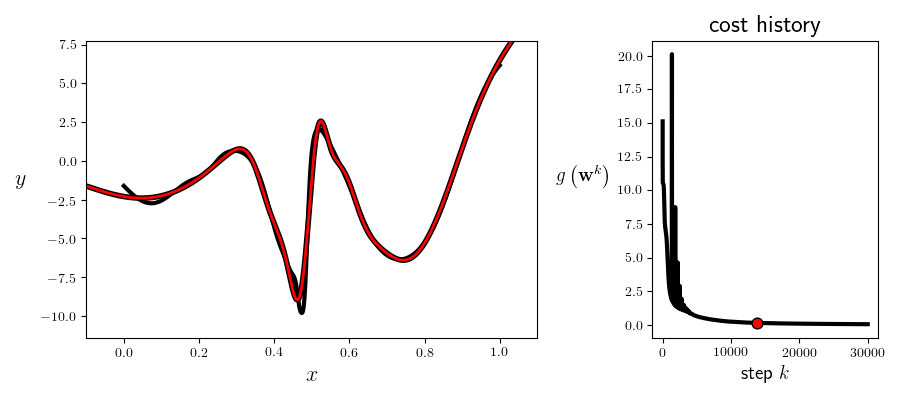
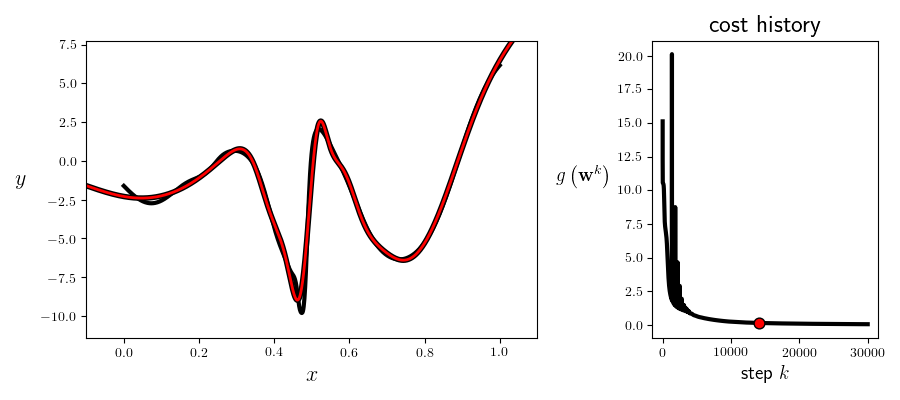
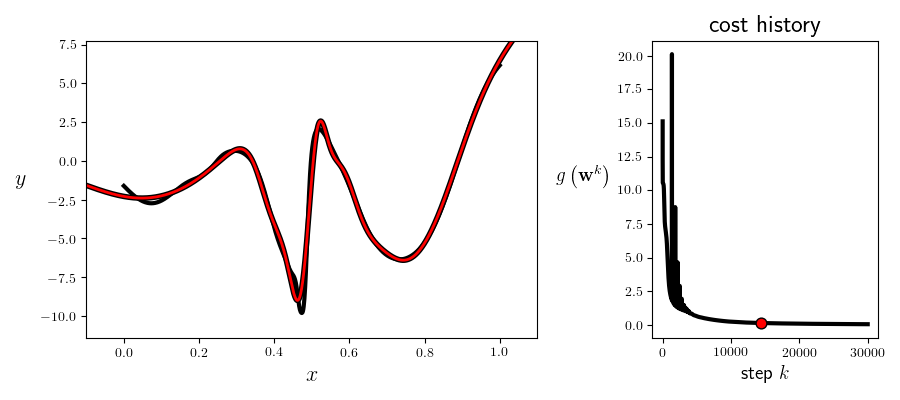
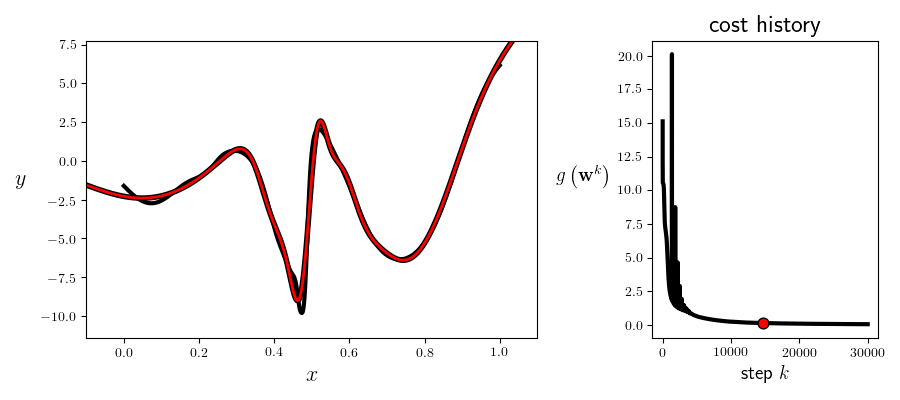
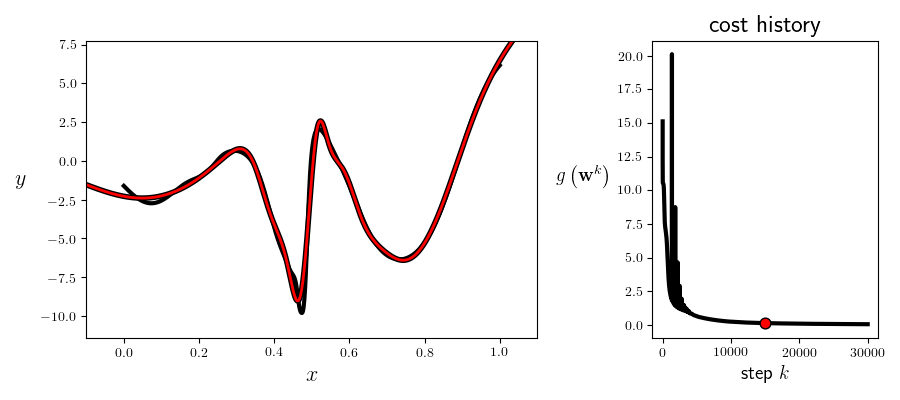
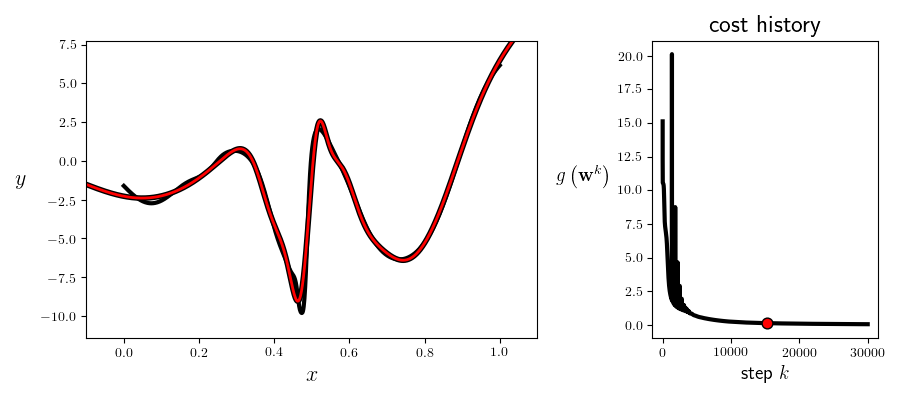
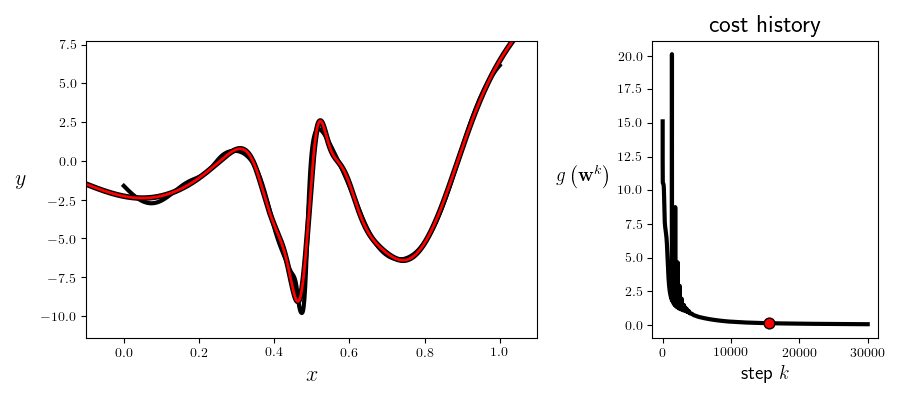
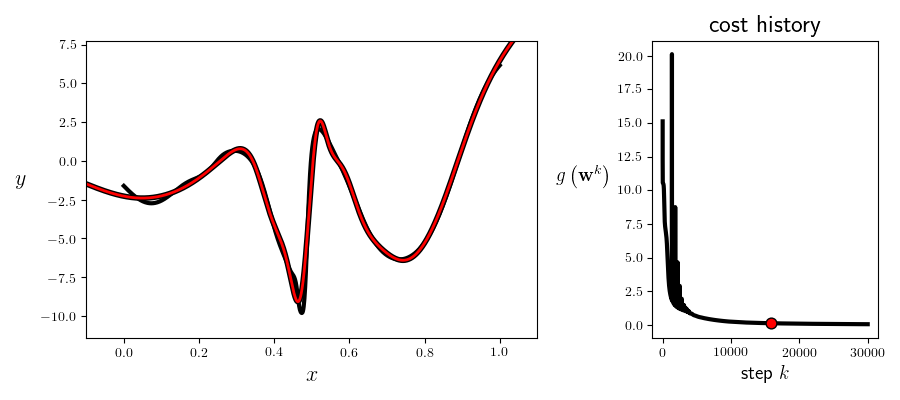
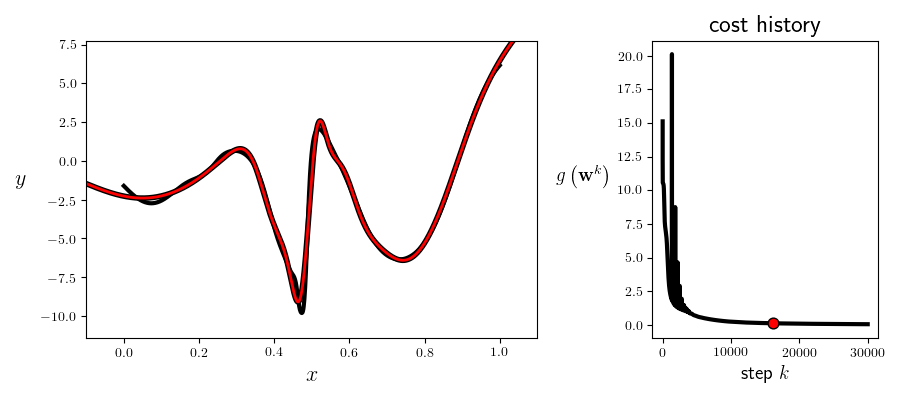
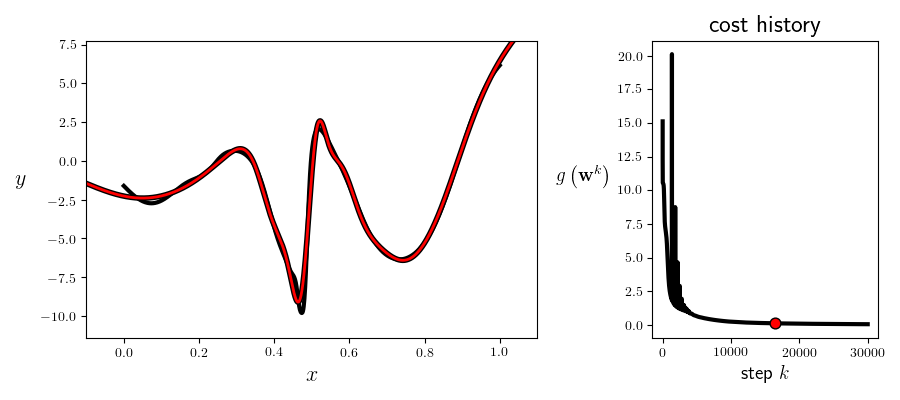
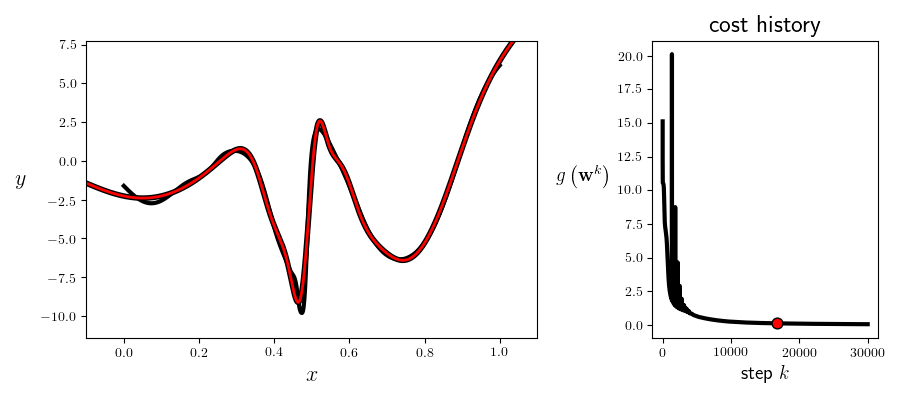
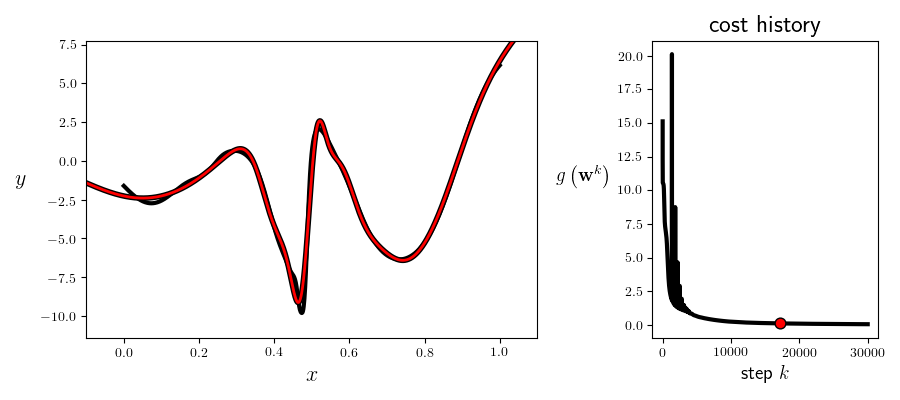
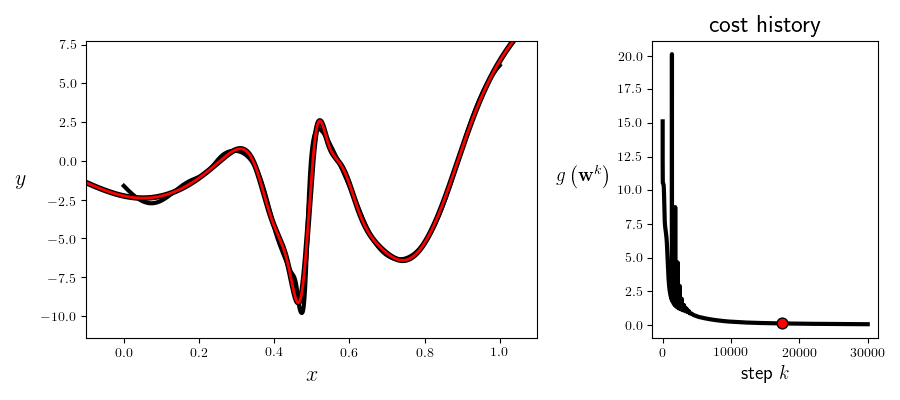
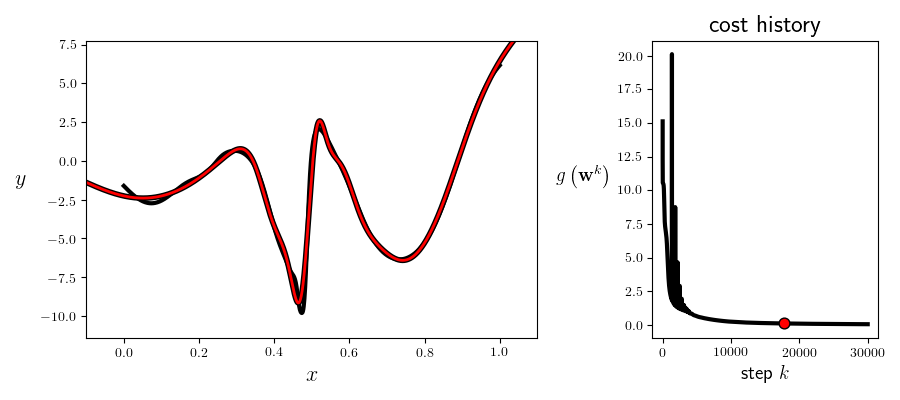
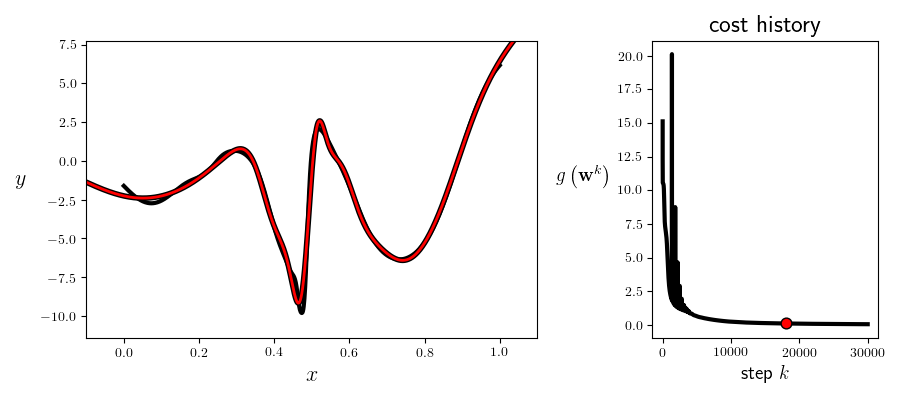
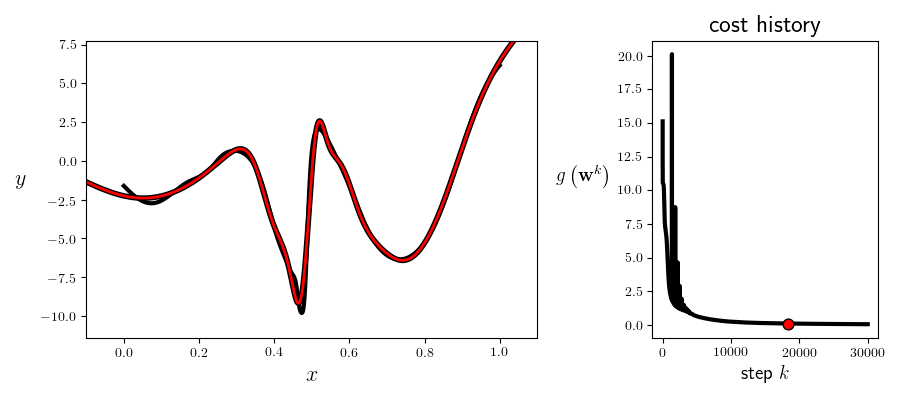
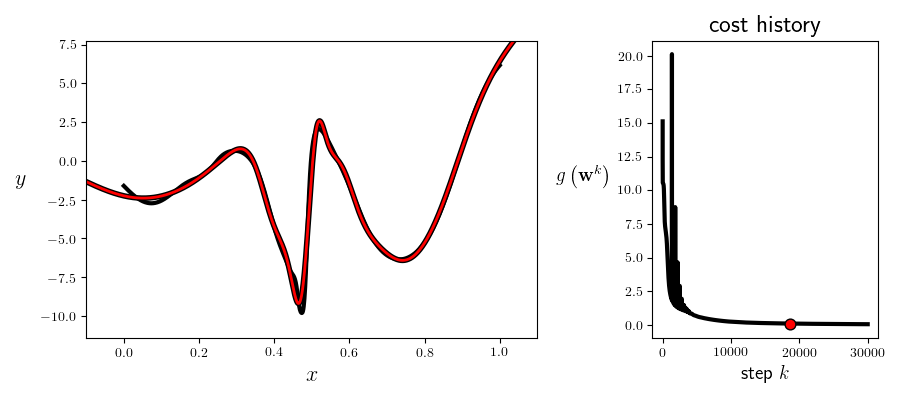
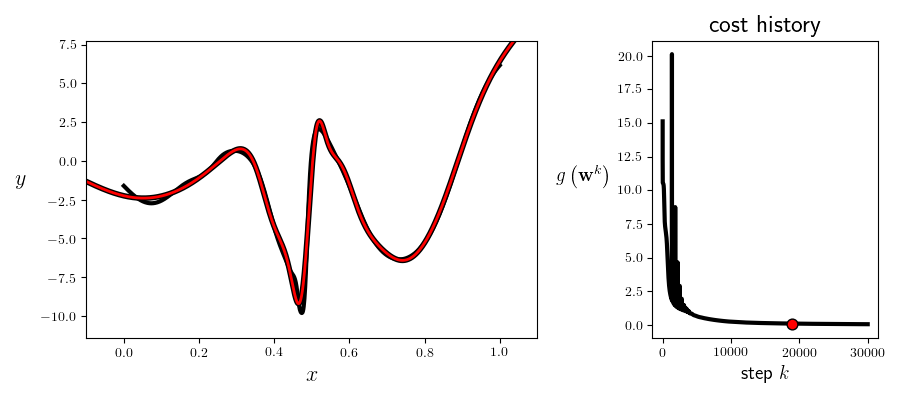
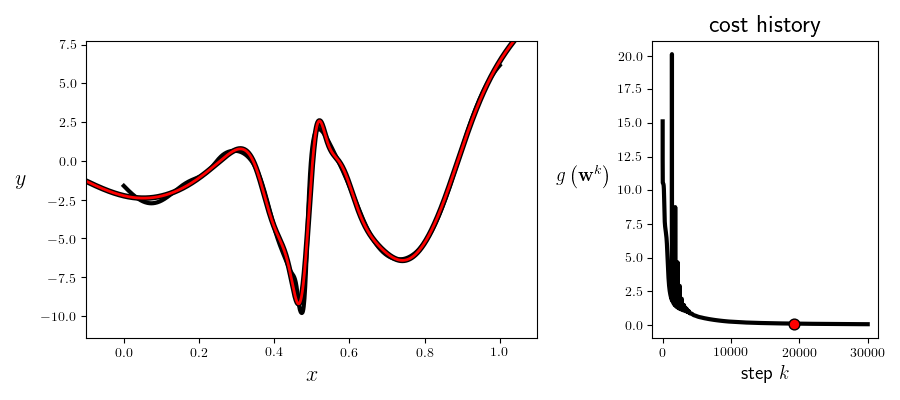
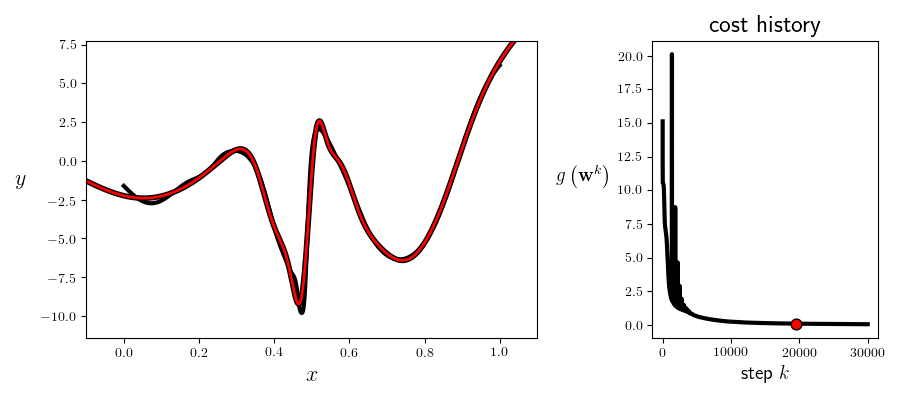
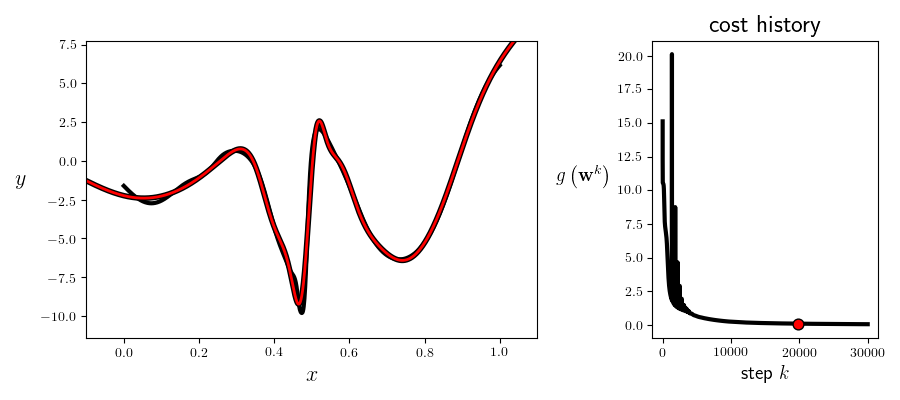
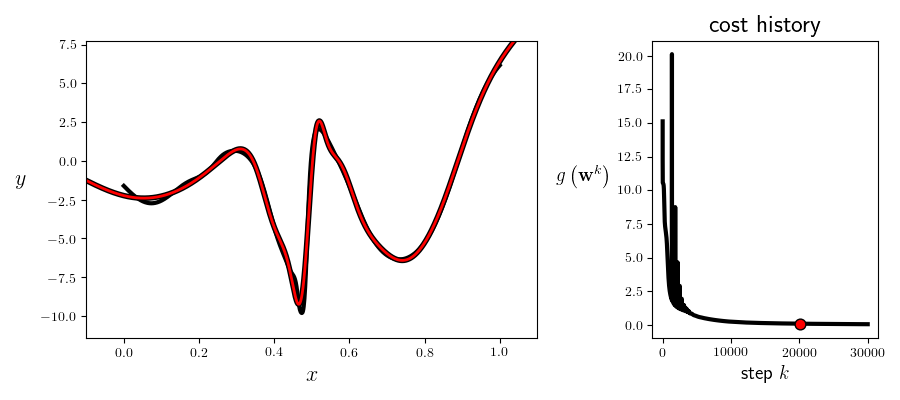
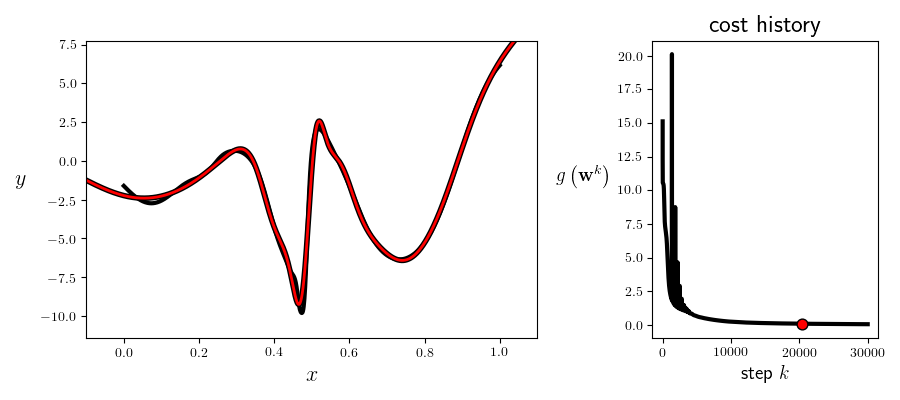
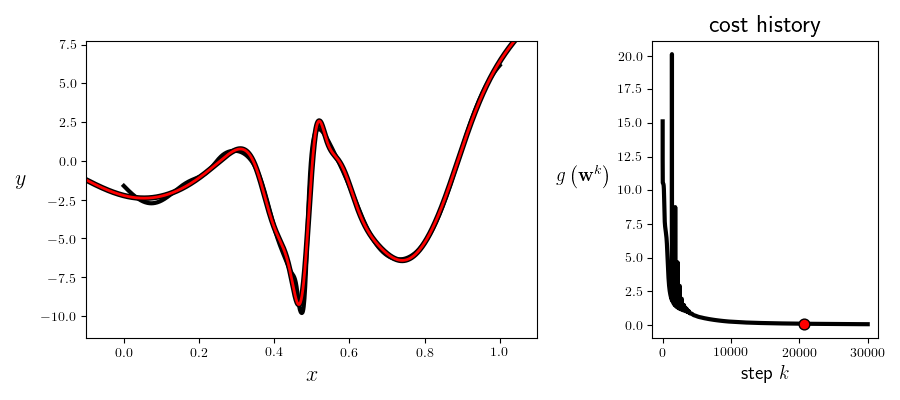
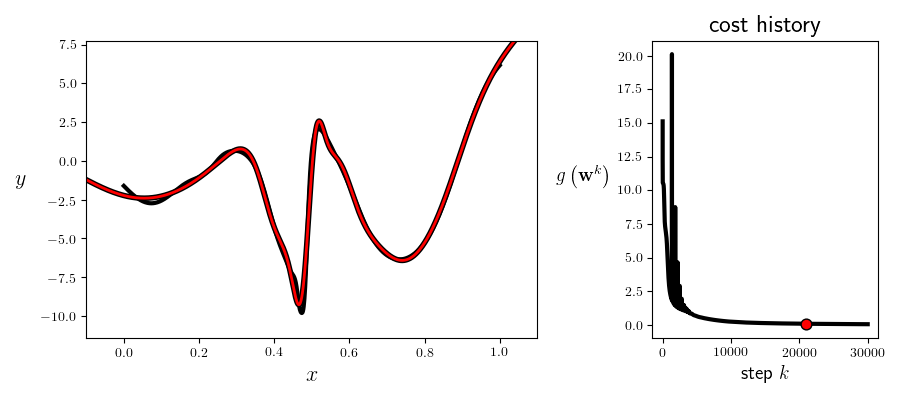
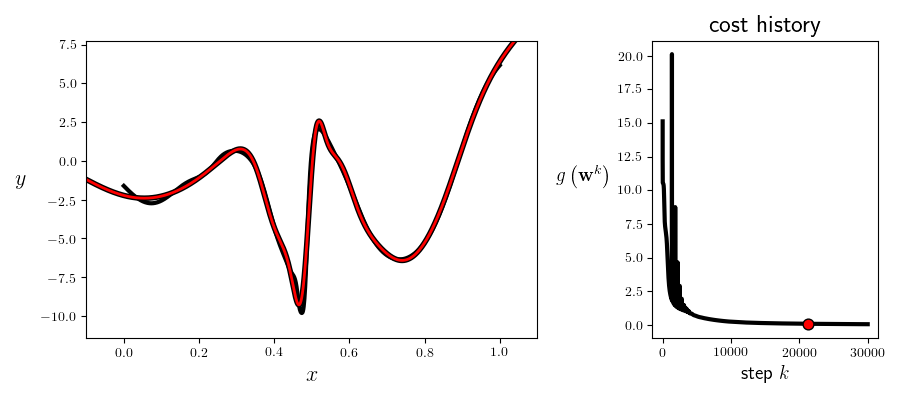
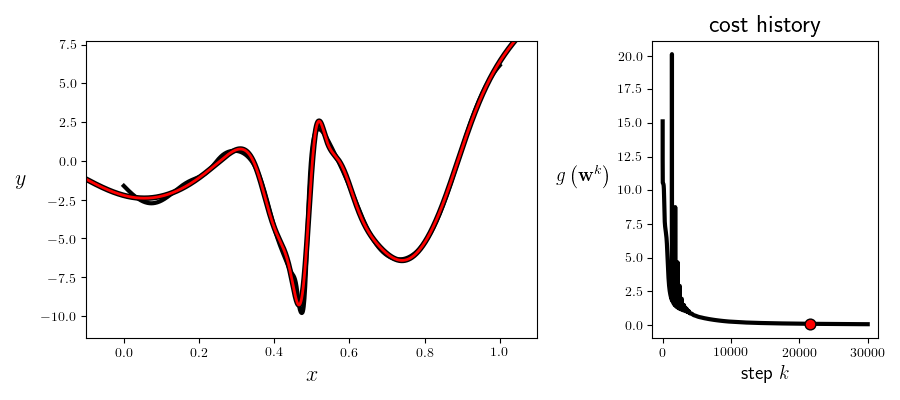
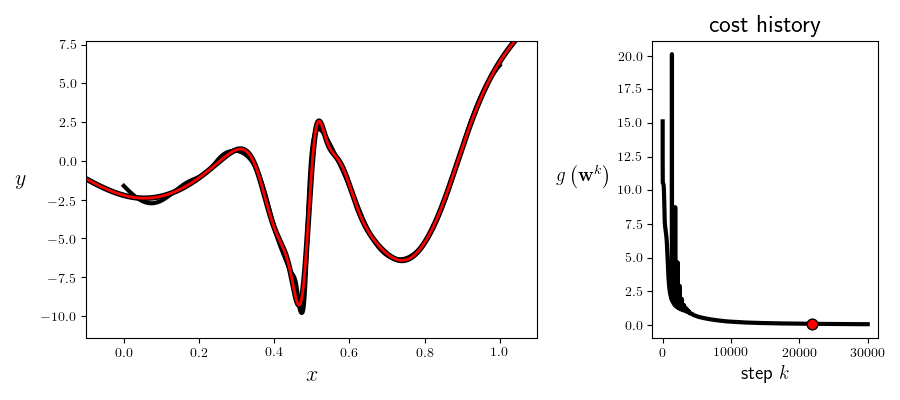
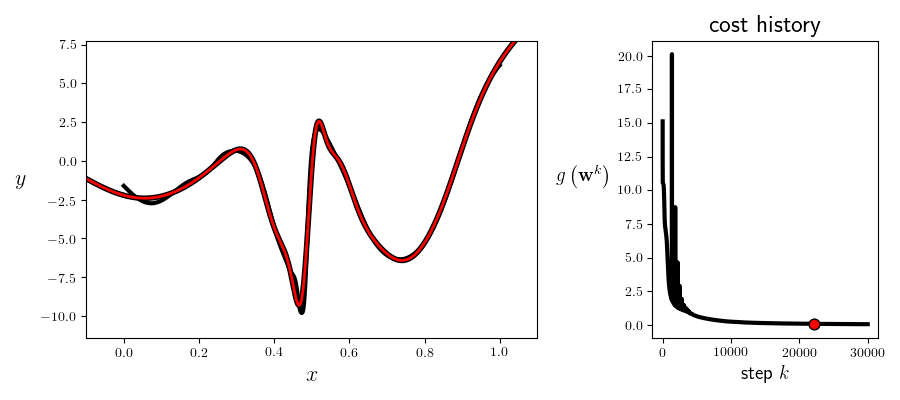
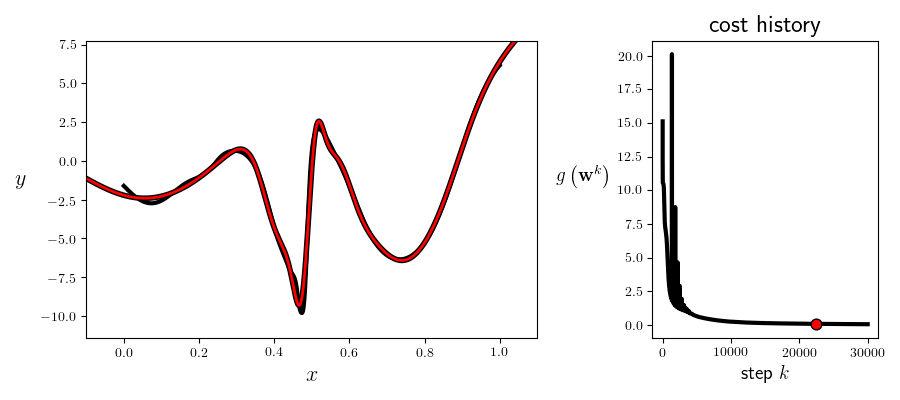
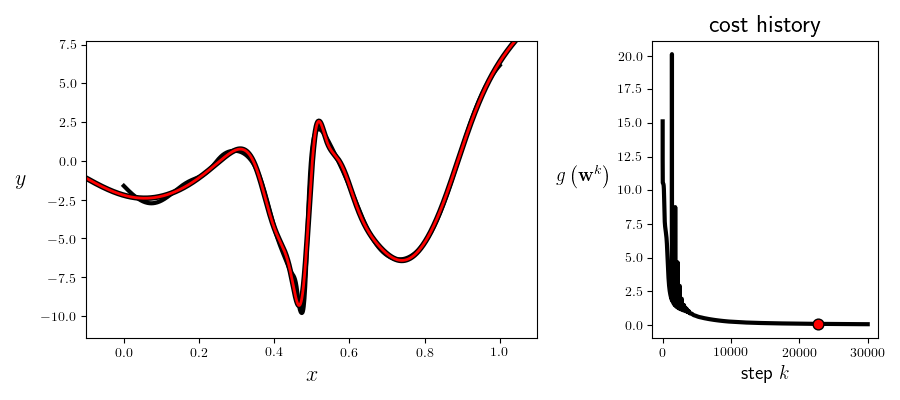
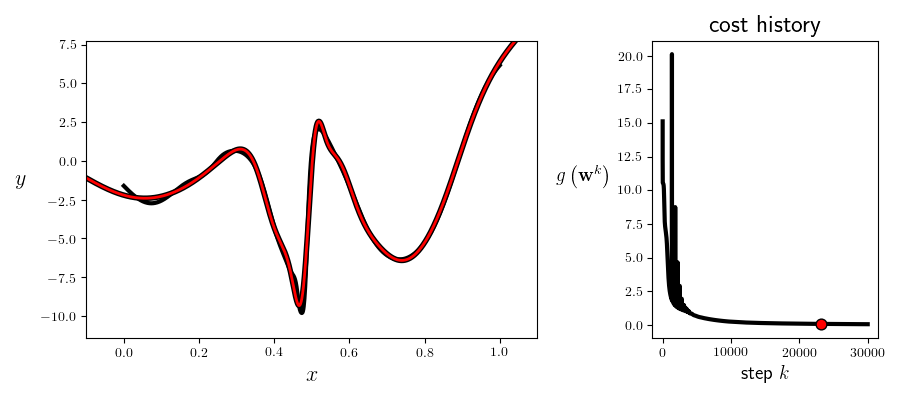
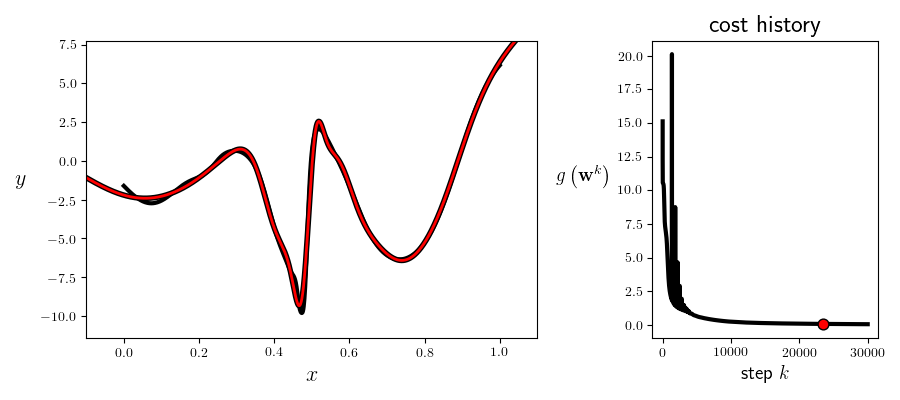
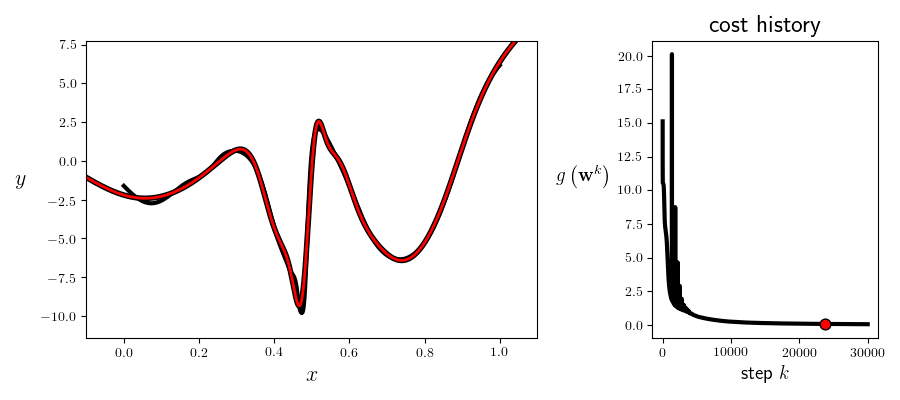
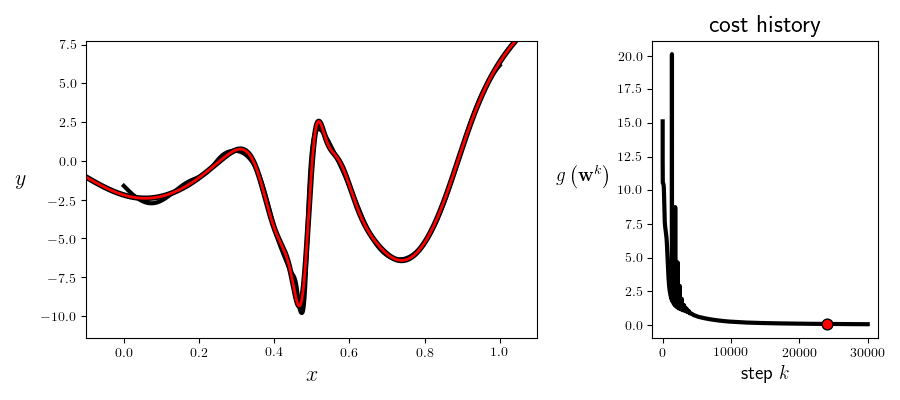
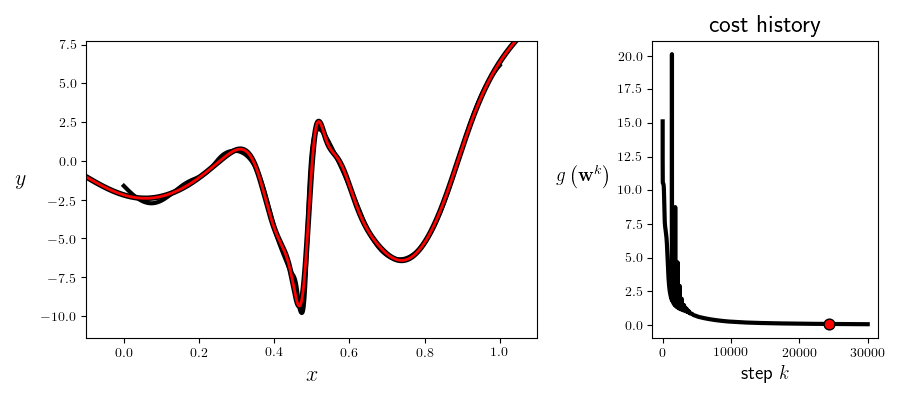
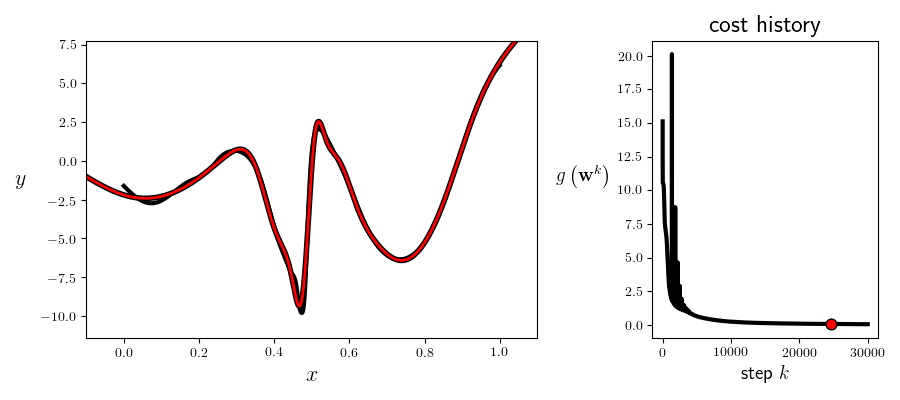
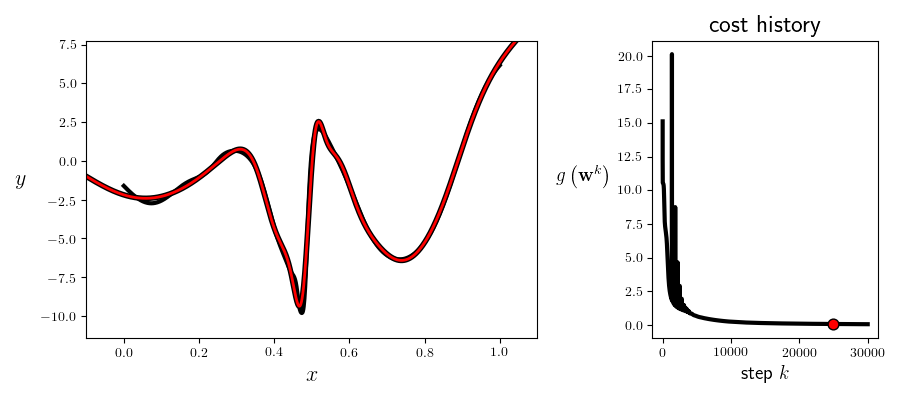
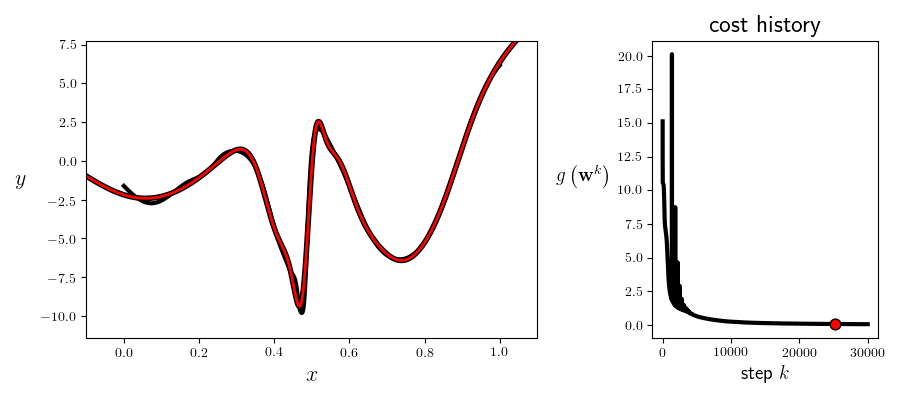
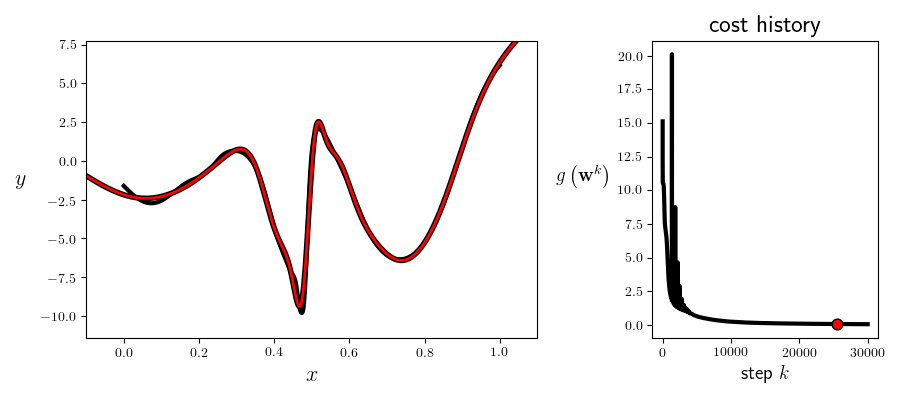
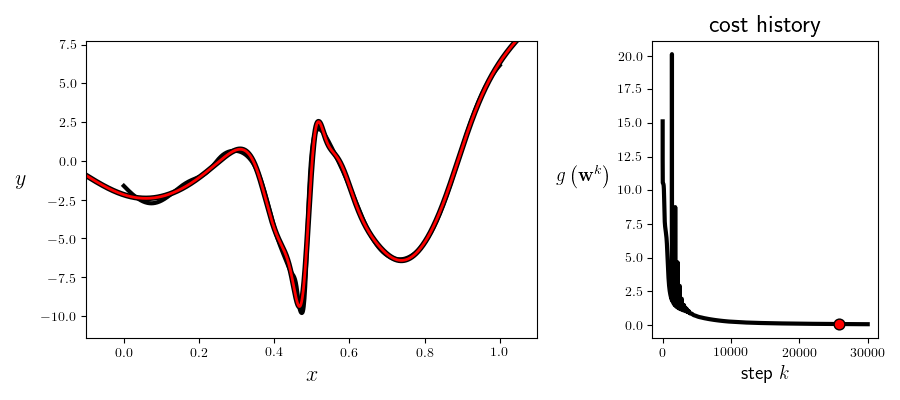
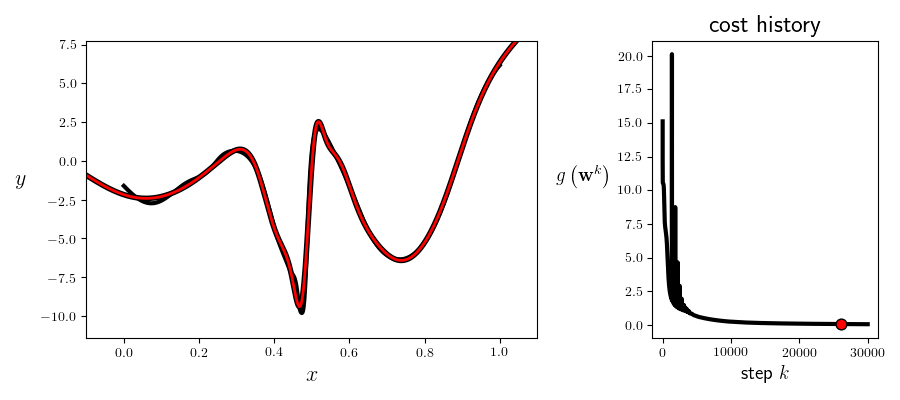
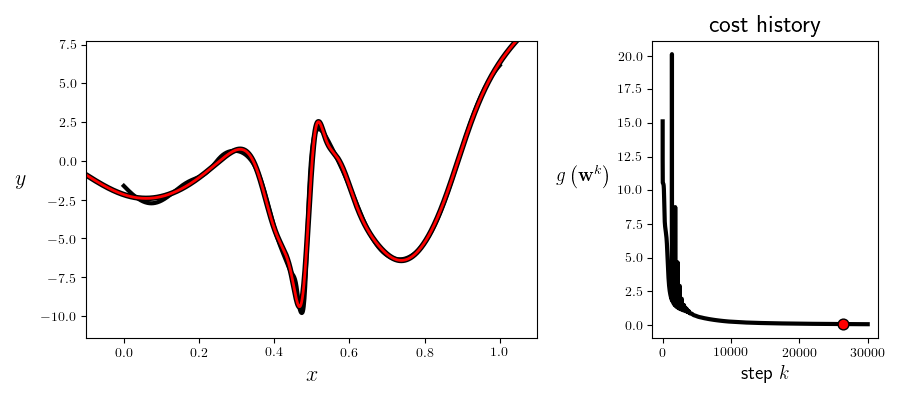
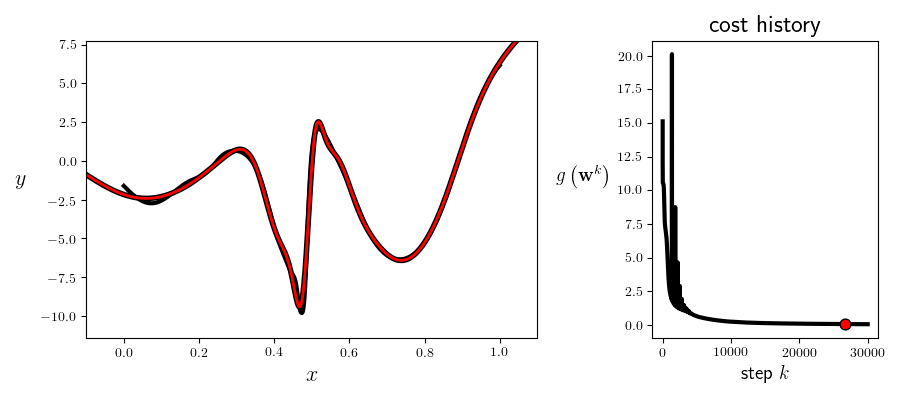
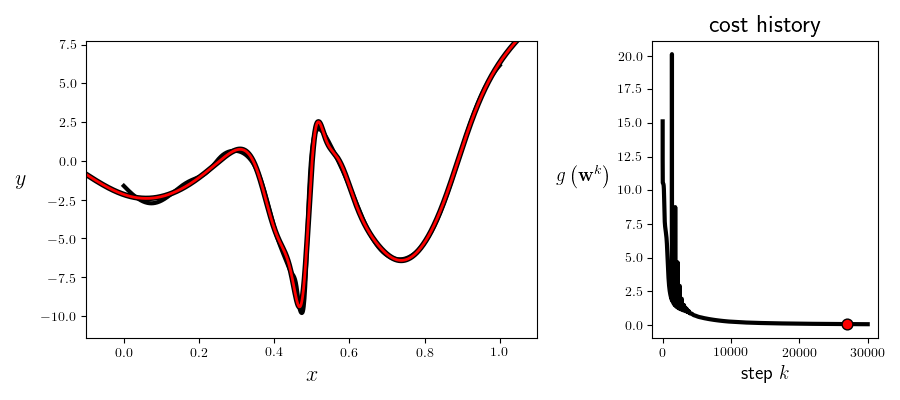
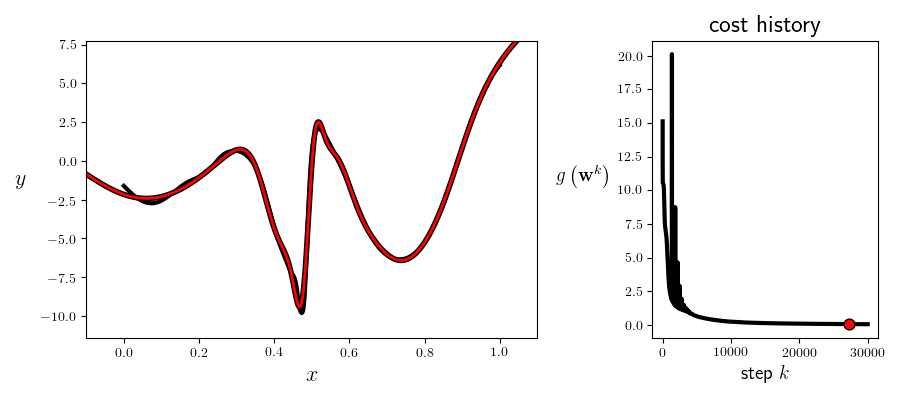
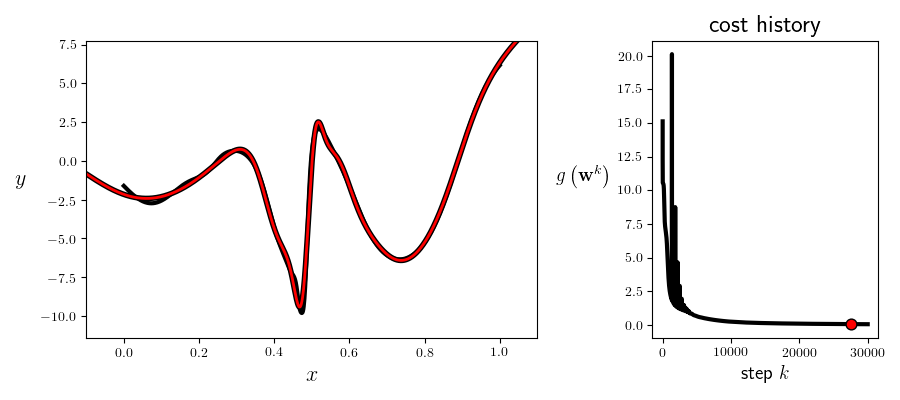
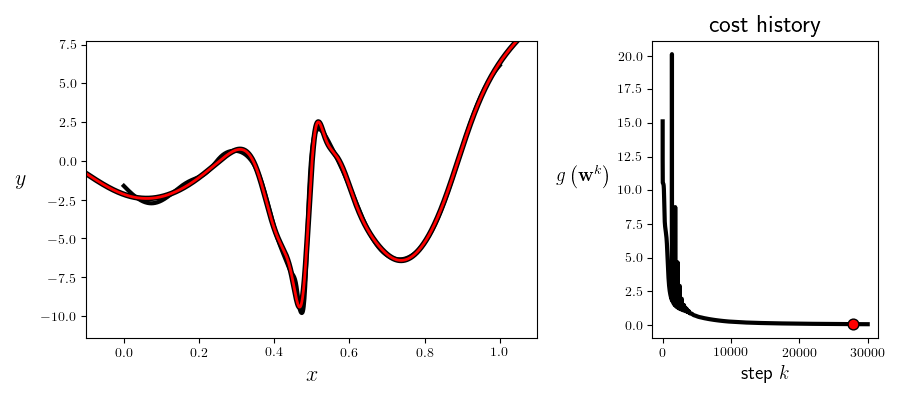
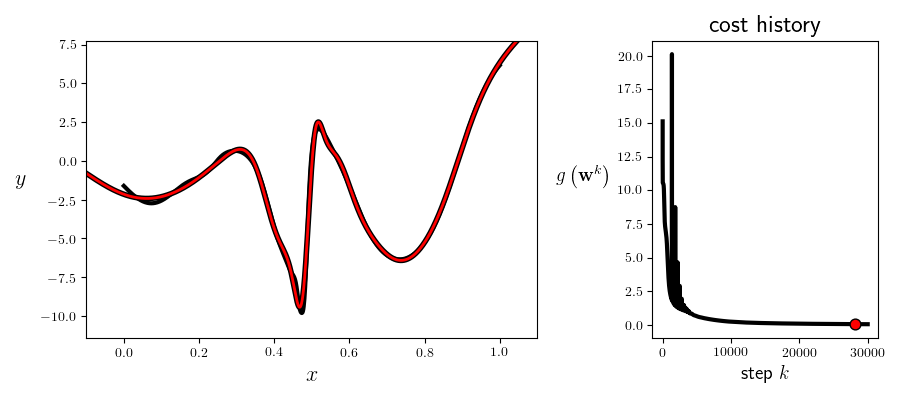
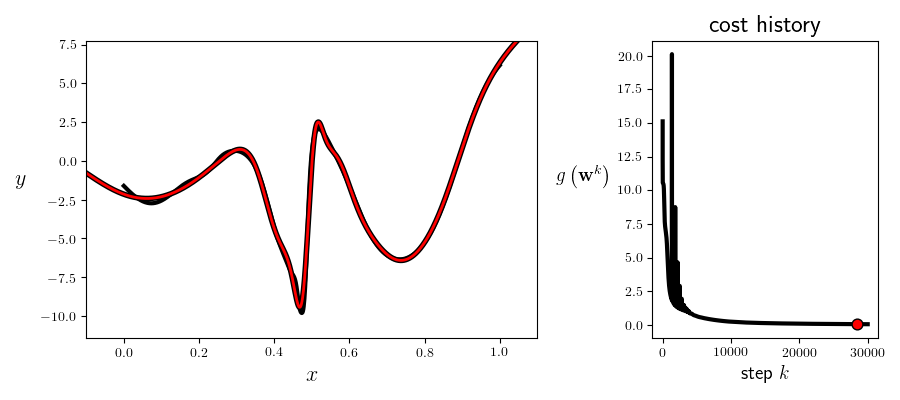
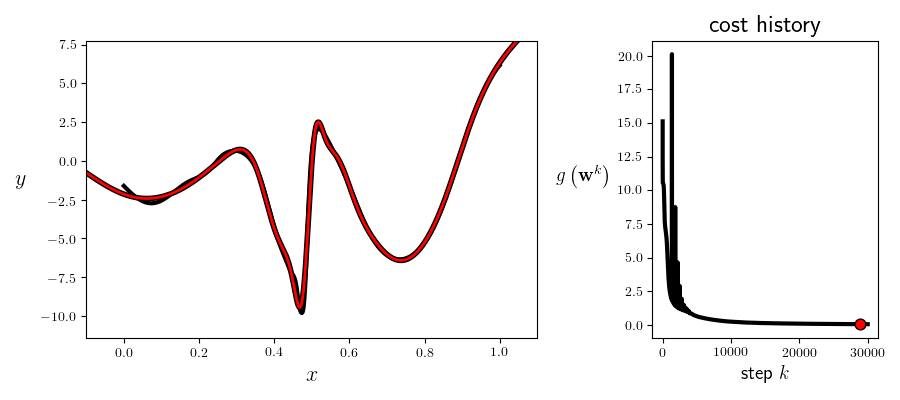
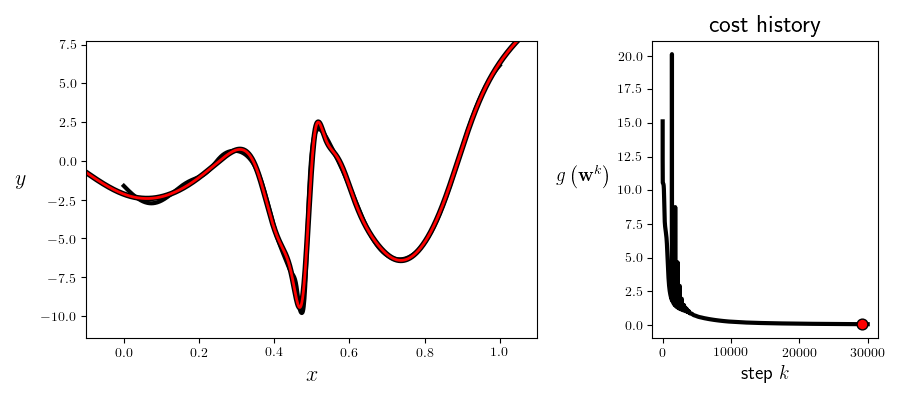
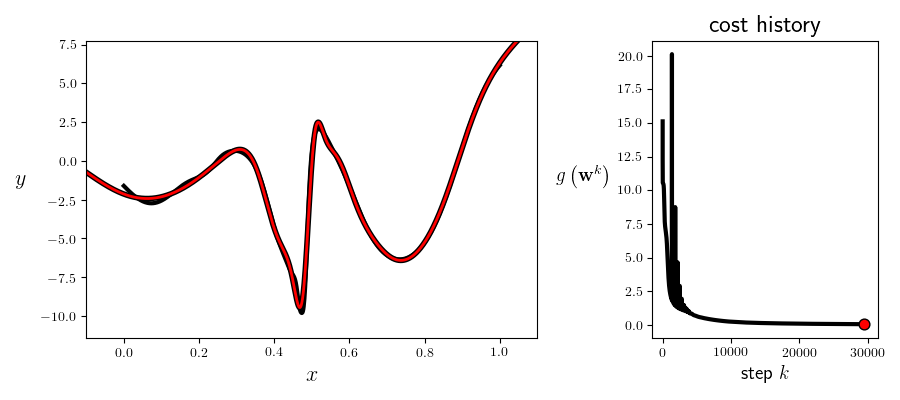
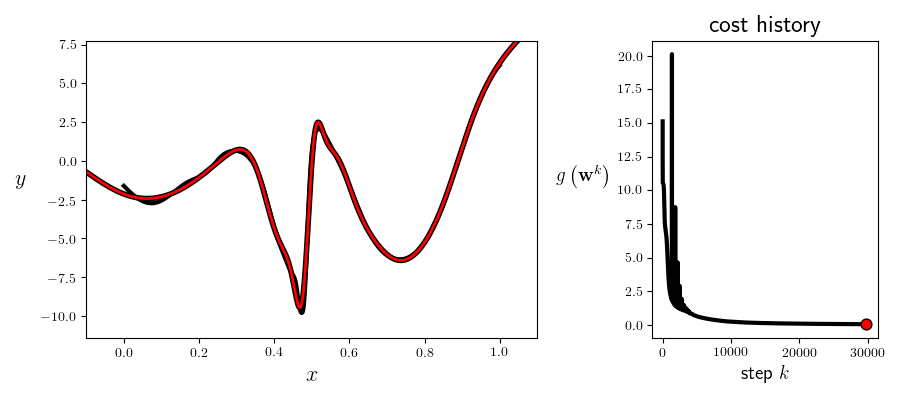
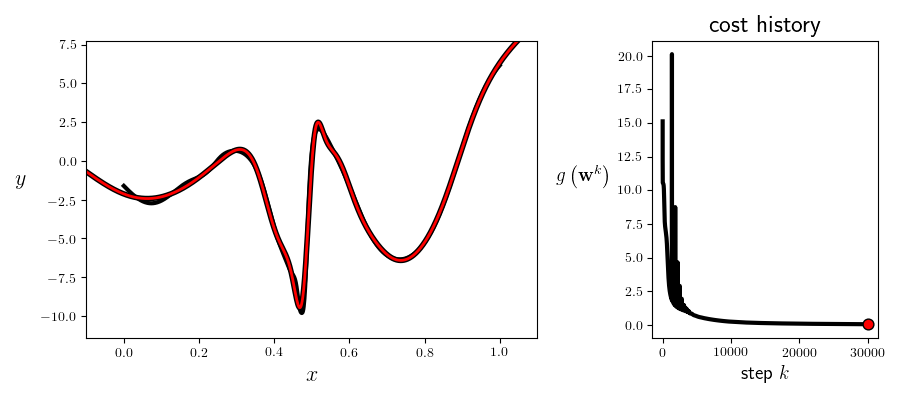

In [98]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'universal_regression_function.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# import the v1 library
mylib1 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib1.choose_features(name = 'multilayer_perceptron',layer_sizes = [1,300,1],activation = 'tanh')

# choose normalizer
mylib1.choose_normalizer(name = 'standard')

# choose cost
mylib1.choose_cost(name = 'least_squares')

# fit an optimization
mylib1.fit(max_its = 30000,alpha_choice = 3*10**(-2))

# load up animator
demo1 = nonlib.run_animators.Visualizer(csvname)

# pluck out a sample of the weight history
num_frames = 100 # how many evenly spaced weights from the history to animate

# animate based on the sample weight history
demo1.animate_1d_regression(mylib1,num_frames,scatter = 'none',show_history = True)

 #### <span style="color:#a50e3e;">Example 3. </span>   Universal approximation of near perfect regression and classification data

With perfect - or near-perfect - data we can employ any universal approximator to achieve excellent representation.  We illustrate this graphically below using a near-perfect sinusoidal regression dataset consisting of $P = 10,000$ points, and regress an increasing number of elements or 'units' from each our three main catalogs / universal approximators detailed in the previous Section.  In the left, middle, and right panels we show the result of fitting an increasing number of polynomial, single layer tanh, and stump units respectively (note: in visualizing the model consisting of stumps we connect each discrete step via a vertical line for visualization purposes).  As you move the slider from left to right you can see the result of fitting more and more of these units, with the result being the same in each instance: we get a better fit to the 'perfect' data. 

Note that because this dataset is a smooth sinusoid, it takes far fewer units of both the polynomial and $\text{tanh}$ approximators to represent it well as compared to the discrete stumps since members of the former more closely resemble the target data.  This sort of occurance is true more generally - while any type of universal approximator can be used to approximate a perfect (or near-perfect) dataset as closely as possible provided enough units are employed, fewer units of a universal approximator whose units more closely resemble the data are typically required.

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# produce visual comparison of different universal approximator fits
demo4 = nonlib.regression_basis_comparison_2d.Visualizer()
csvname = datapath + 'sin_function.csv'
demo4.load_data(csvname)
demo4.brows_fits(num_elements = [v for v in range(1,200,1)],scatter = 'on')

beginning animation rendering...


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1026, in _start
    self._init_draw()
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1750, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1775, in _draw_frame
    raise RuntimeError('The animation function must return a '
RuntimeError: The animation function must return a sequence of Artist objects.


RuntimeError: The animation function must return a sequence of Artist objects.

#### <span style="color:#a50e3e;">Example 5. </span>   Examples of universal approximation with perfect two-class classification datasets

In the top row of the figure below show four instances of near-perfect two-class classification data each consisting of $P=10,000$ points.  In each instance those points colored red have label value $+1$, and those colored blue label value $-1$.  Plotted in the second row of this figure are the corresponding datasets plotted 'from the side'. 

Each of these can be approximated effectively using any of the three catalogs of universal approximators previously discussed, provided of course that the number of them $B$ is chosen large enough and the corresponding parameters tuned properly.  In the third and fourth rows we show the resulting fit from employing $B = 30$ polynomial approximators using a Least Squares and Softmax cost respectively.  In minimizing the latter cost we tune the parameters of our model to provide a approximation since it is of course specifically designed to deal with data pairs with values restricted to $\pm 1$.  Note that the approximations shown in the final row are passed through the $\text{tanh}$ function.

<tr>
<td>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/indicators_feture_space_view.png' width="50%" height="25%" alt=""/>
</td>
</tr>

<figure>
 <figcaption> <strong>Figure 2:</strong> <em> 
(top row) Four instances of near-perfect classification data.  (second row) The corresponding data shown in 'from the side'. (third row) Respective polynomial approximations to each indicator function where $B=30$ in each instance. (bottom row) The associated logistic approximations match the original indicator functions very closely.
</em>
</figcaption>
</figure>

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.